<a href="https://colab.research.google.com/github/ojaashampiholi/Techpoint-Covid19/blob/dev/TechPoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Counties Data Forecasting

In [1]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Bidirectional
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.backend import clear_session
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [38]:
url = 'https://github.com/nytimes/covid-19-data/blob/master/us-counties.csv?raw=true'

df = pd.read_csv(url)
df = df[df['state']=='Indiana']
df = df[['date', 'county', 'cases', 'deaths']]
df

date      county  cases  deaths
613     2020-03-06      Marion      1       0
697     2020-03-07      Marion      1       0
794     2020-03-08   Hendricks      1       0
795     2020-03-08      Marion      1       0
914     2020-03-09   Hendricks      2       0
...            ...         ...    ...     ...
292540  2020-07-03  Washington     66       1
292541  2020-07-03       Wayne    312       6
292542  2020-07-03       Wells     88       1
292543  2020-07-03       White    260      10
292544  2020-07-03     Whitley     88       4

[9418 rows x 4 columns]

In [39]:
def windowData(training_scaled, n_len):
  x_train = []
  y_train = []
  for i in range(n_len,training_scaled.shape[0]):
    x_train.append(training_scaled[i-n_len:i, :])
    y_train.append(training_scaled[i,:])

  x_train,y_train = np.array(x_train),np.array(y_train)
  #print(x_train.shape, y_train.shape)
  return x_train,y_train

In [ ]:
def processData(df, n_len = 15):
  counties = df['county'].unique()
  trainX = np.random.randn(1,n_len, 2)
  trainY = np.random.randn(1,2)
  #print(trainX, trainY)
  tempX = []
  tempY = []
  for county in counties:
    df1 = df[df['county']==county]
    if df1.shape[0]<80:
      continue
    df2 = df1[['cases', 'deaths']]
    #df2 = df2.diff(periods=1)
    #print(df2)
    df2 = df2.values
    tempX, tempY = windowData(df2, n_len)
    trainX = np.concatenate((trainX, tempX), axis = 0)
    trainY = np.concatenate((trainY, tempY), axis = 0)

  trainX , trainY = trainX[1:,:,:] ,  trainY[1:,:]
  return trainX , trainY

trainX , trainY = processData(df, 15)
print("After Preprocessing the data")
print(trainX.shape, trainY.shape)
batchSize = 512

After Preprocessing the data
(7941, 15, 2) (7941, 2)


In [ ]:
clear_session()

regressor = Sequential()
regressor.add(LSTM(units = batchSize,return_sequences = True,input_shape = (trainX.shape[1],trainX.shape[2])))
regressor.add(LSTM(units = 800,return_sequences = True))
regressor.add(LSTM(units = 600,return_sequences = True))
regressor.add(LSTM(units = 400,return_sequences = False))
regressor.add(Dense(units = 128, activation = 'relu'))
regressor.add(Dropout(0.15))
regressor.add(Dense(units = 256, activation = 'relu'))
regressor.add(Dropout(0.15))
regressor.add(Dense(units = 128, activation = 'relu'))
regressor.add(Dropout(0.1))
regressor.add(Dense(units = 64, activation = 'relu'))
regressor.add(Dropout(0.05))
regressor.add(Dense(units = 2))

regressor.compile(optimizer = 'adam',loss = 'mean_absolute_error')
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 512)           1054720   
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 800)           4201600   
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 600)           3362400   
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1601600   
_________________________________________________________________
dense (Dense)                (None, 128)               51328     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3

In [ ]:
regressor.fit(trainX,trainY,epochs = 150, batch_size = batchSize)
#new_regressor.fit(trainX,trainY,epochs = 3, batch_size = batchSize)

Epoch 1/150
16/16 [==============================] - 1s 78ms/step - loss: 157.9512
Epoch 2/150
16/16 [==============================] - 1s 78ms/step - loss: 151.1119
Epoch 3/150
16/16 [==============================] - 1s 77ms/step - loss: 150.4947
Epoch 4/150
16/16 [==============================] - 1s 77ms/step - loss: 150.3677
Epoch 5/150
16/16 [==============================] - 1s 77ms/step - loss: 150.3292
Epoch 6/150
16/16 [==============================] - 1s 76ms/step - loss: 150.3566
Epoch 7/150
16/16 [==============================] - 1s 77ms/step - loss: 150.3118
Epoch 8/150
16/16 [==============================] - 1s 77ms/step - loss: 150.1607
Epoch 9/150
16/16 [==============================] - 1s 77ms/step - loss: 150.0404
Epoch 10/150
16/16 [==============================] - 1s 77ms/step - loss: 149.1667
Epoch 11/150
16/16 [==============================] - 1s 77ms/step - loss: 144.6689
Epoch 12/150
16/16 [==============================] - 1s 77ms/step - loss: 125.6429
E

In [ ]:
path = f"{os.getcwd()}/drive/My Drive/Techpoint/checkpoint.h5"
regressor.save(path) 
#new_regressor.save(path)

In [ ]:
path = f"{os.getcwd()}/drive/My Drive/Techpoint/checkpoint.h5"
new_regressor= load_model(path)

In [ ]:
def processValData(training_scaled, n_len = 15):
  x_train = []
  y_train = []
  for i in range(n_len,len(training_scaled)):
      x_train.append(training_scaled[i-n_len:i, :])
      y_train.append(training_scaled[i,:])

  x_train,y_train = np.array(x_train),np.array(y_train)
  return x_train,y_train

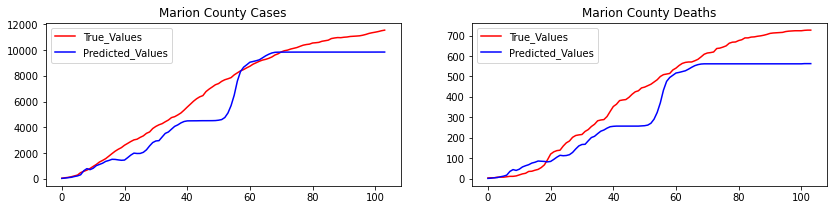

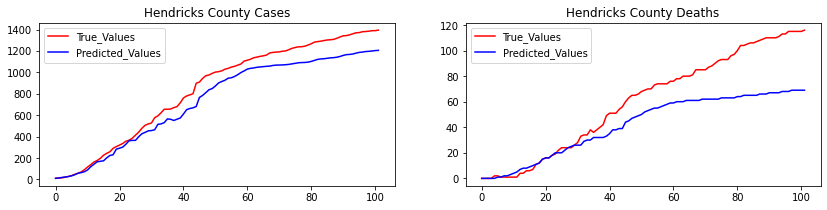

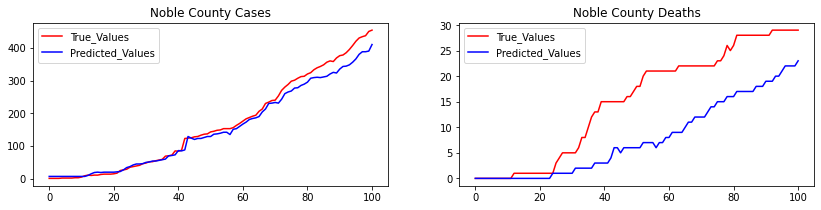

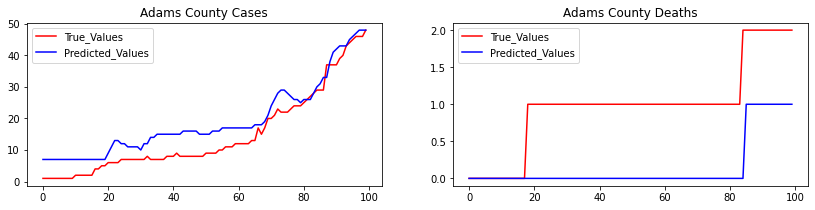

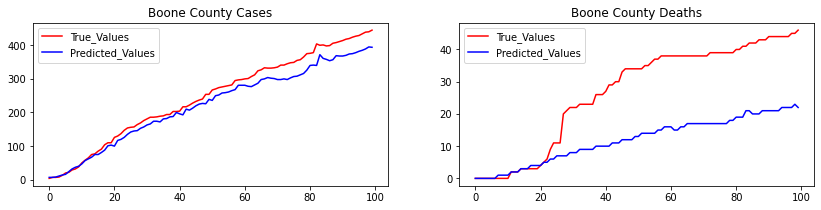

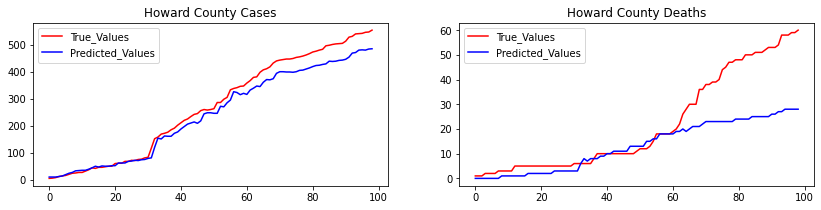

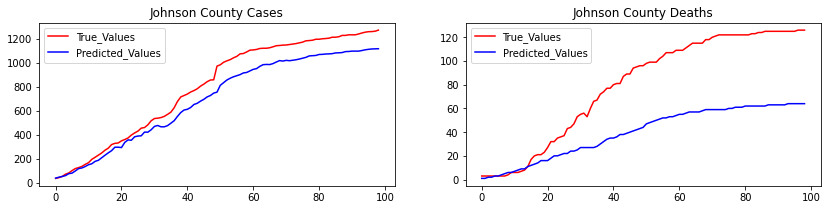

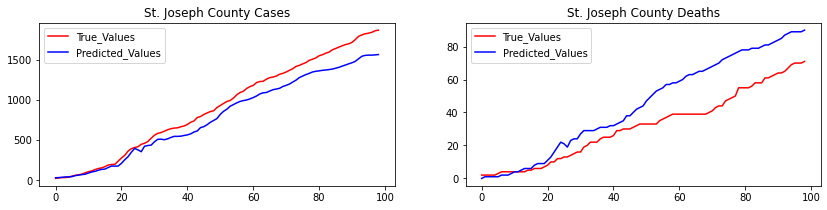

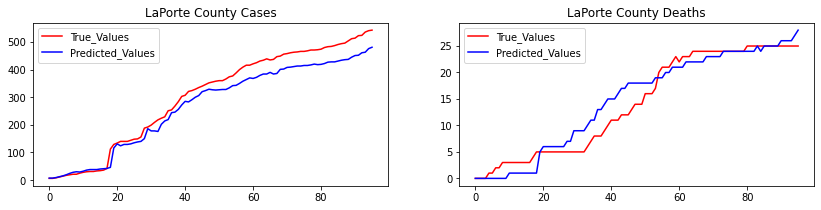

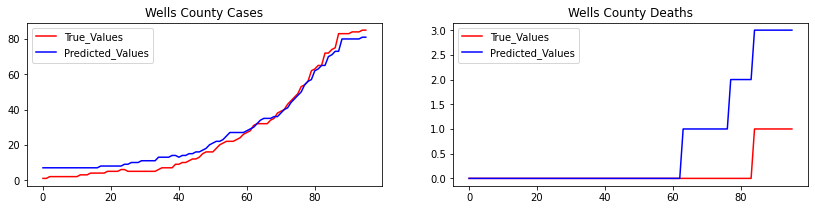

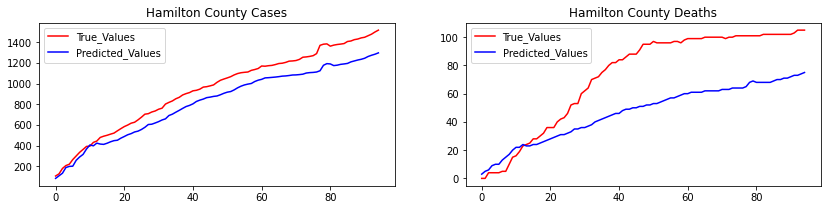

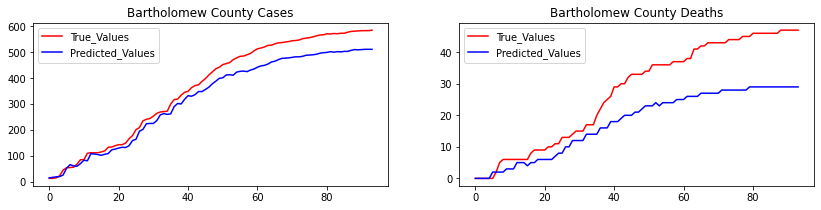

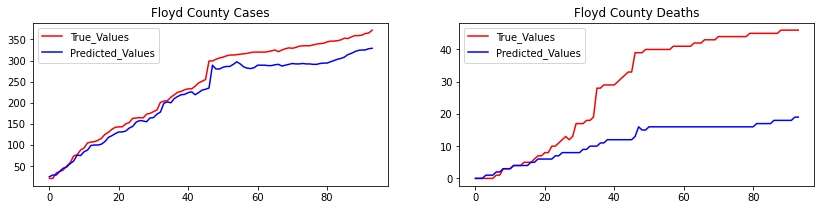

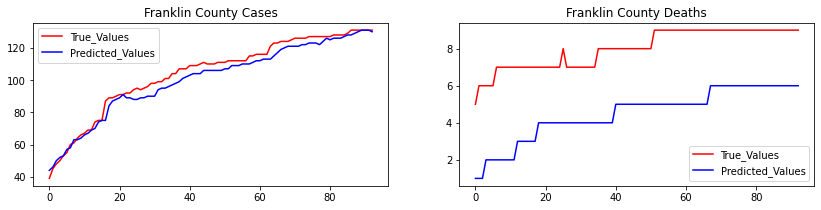

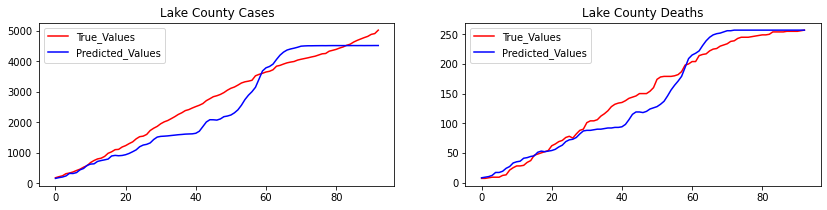

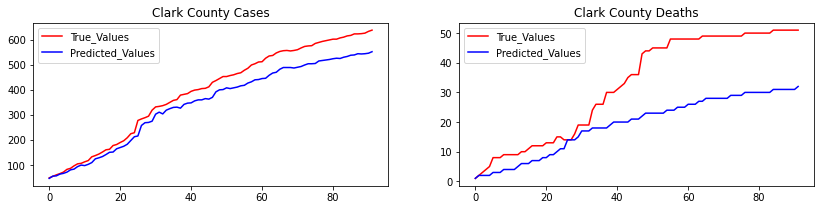

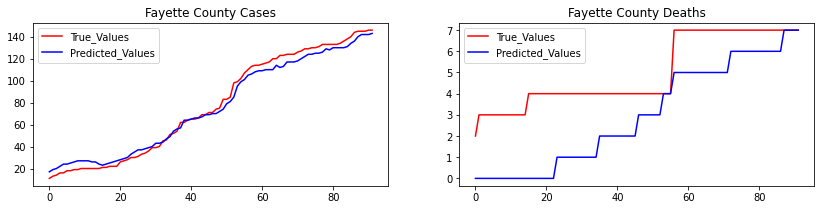

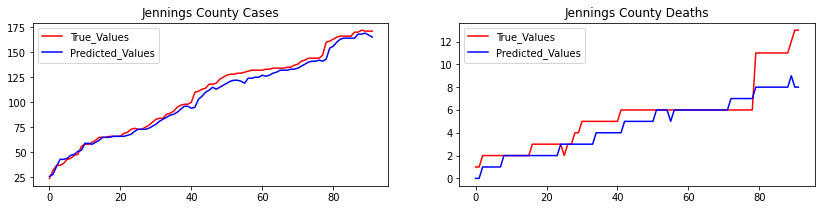

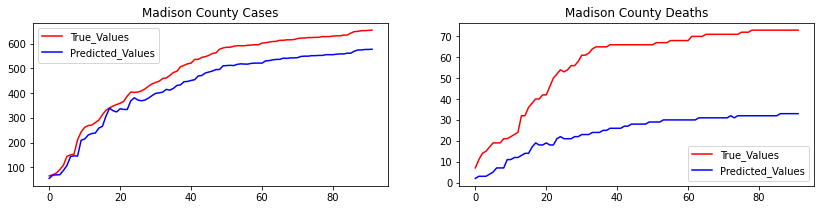

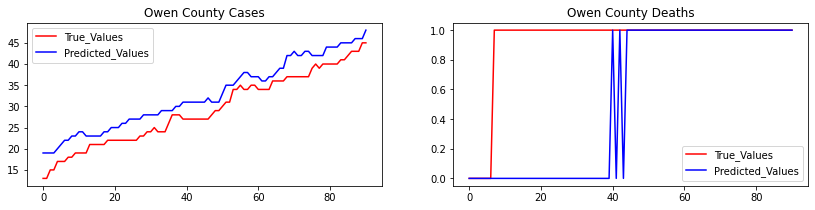

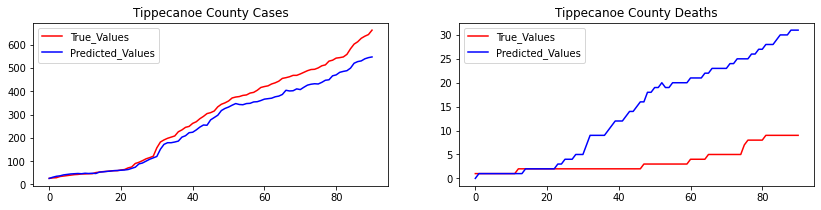

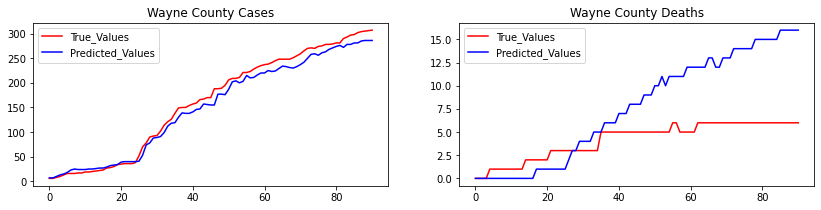

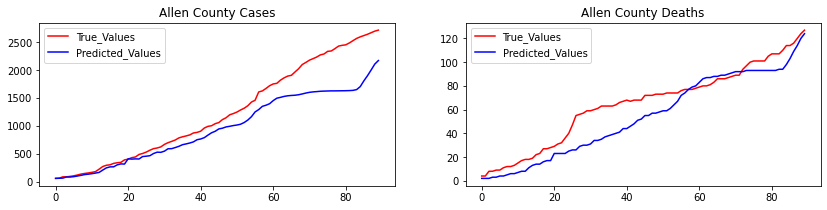

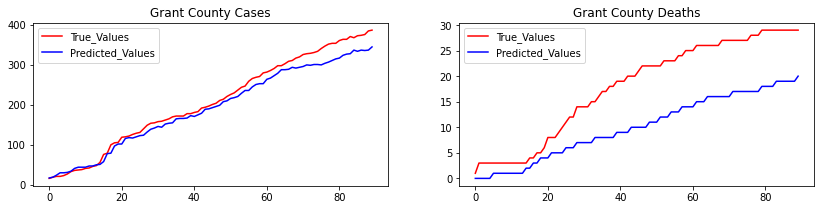

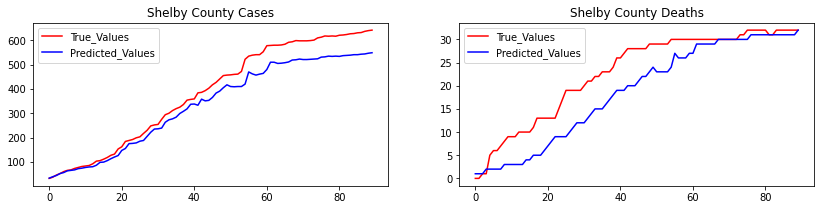

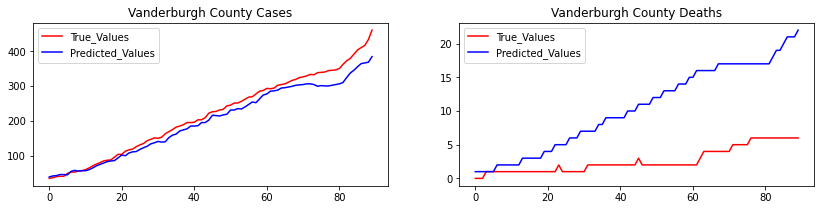

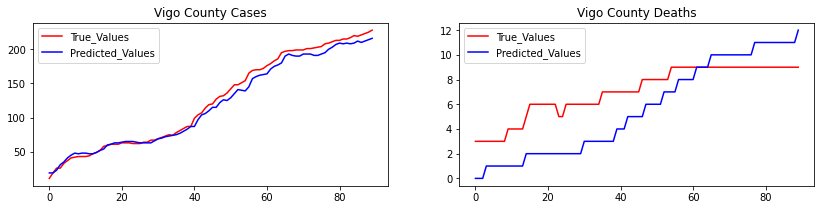

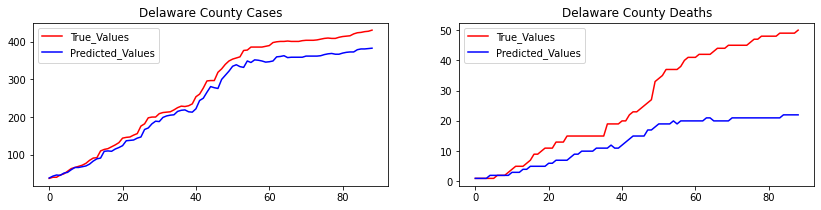

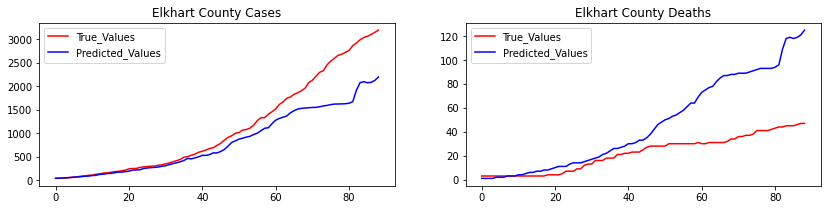

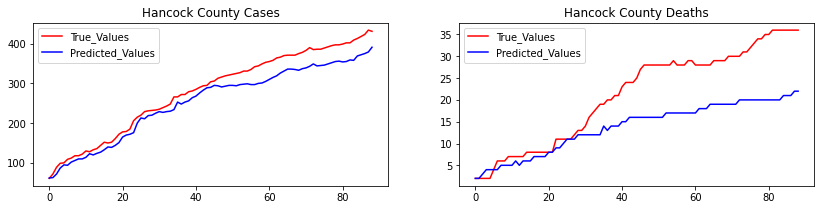

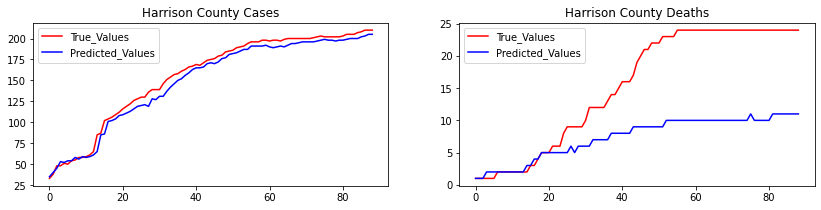

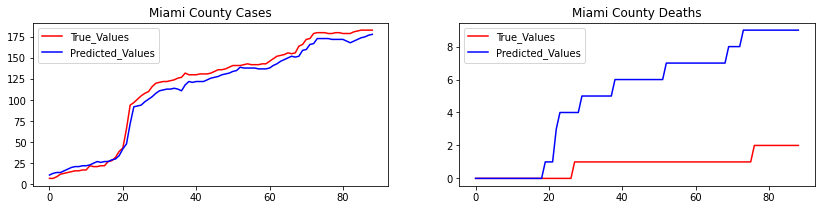

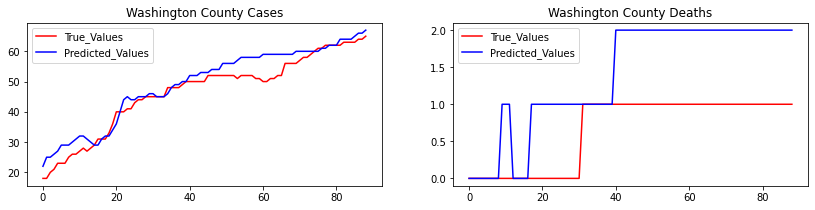

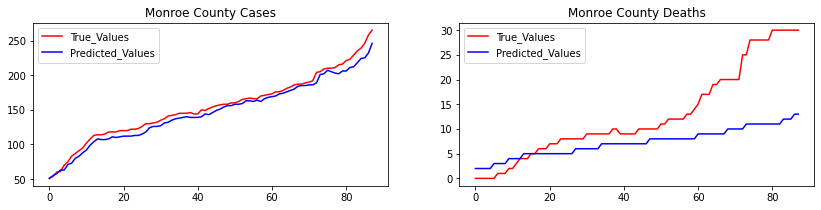

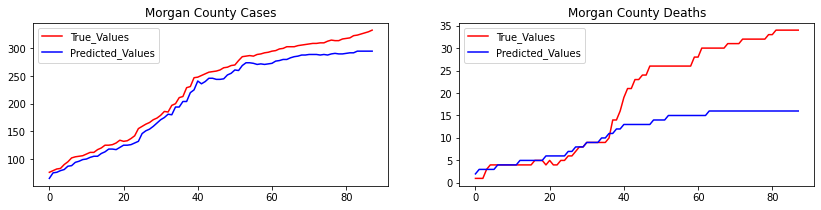

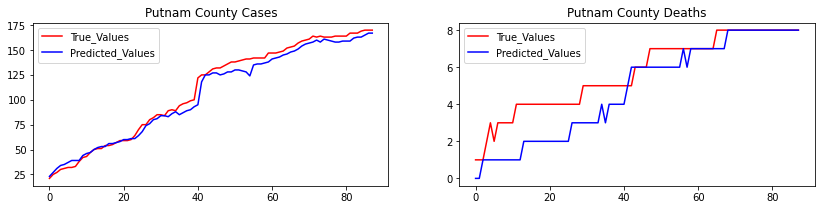

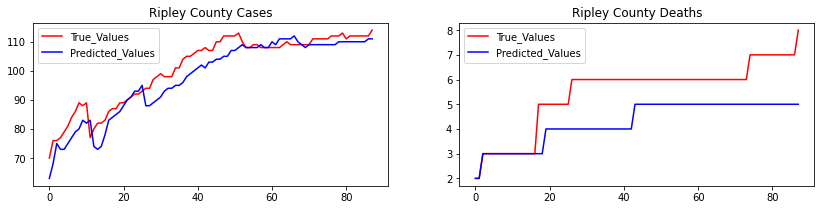

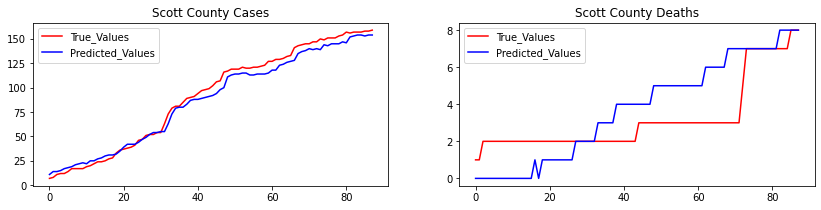

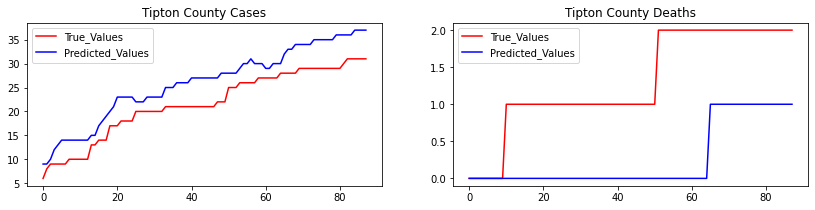

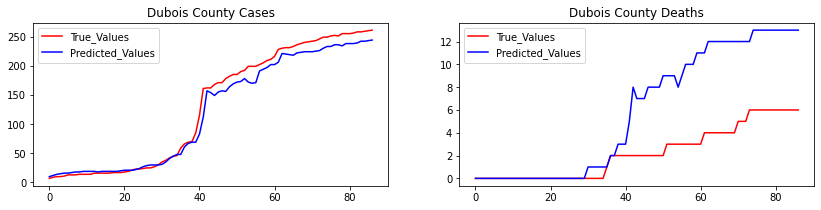

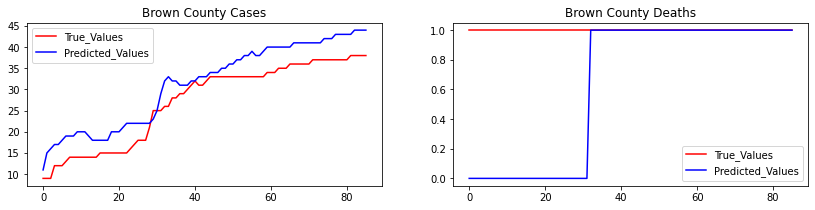

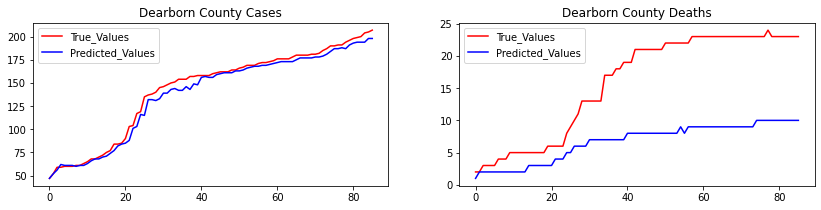

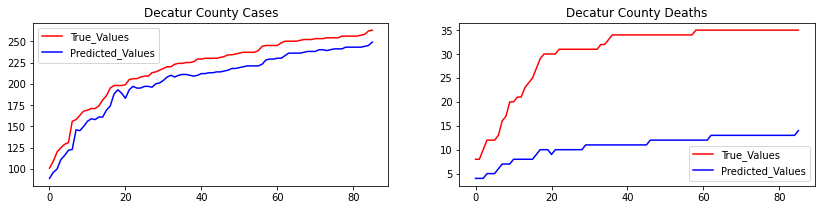

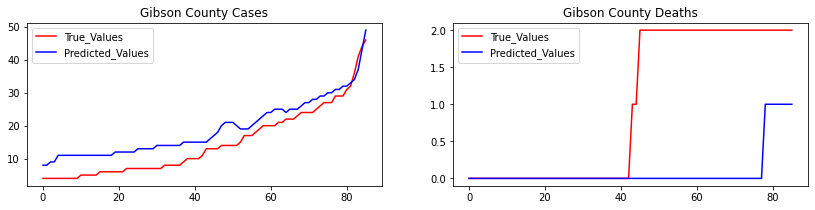

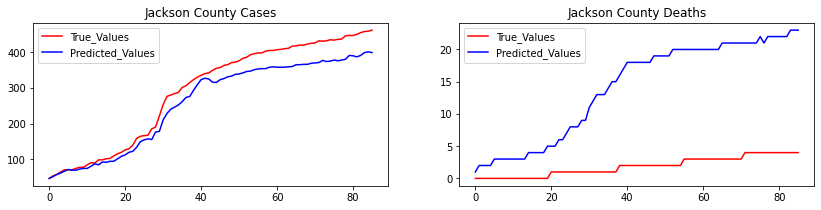

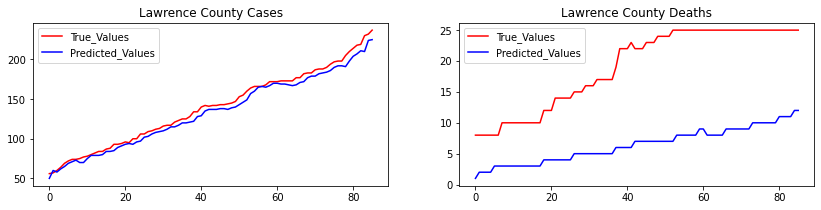

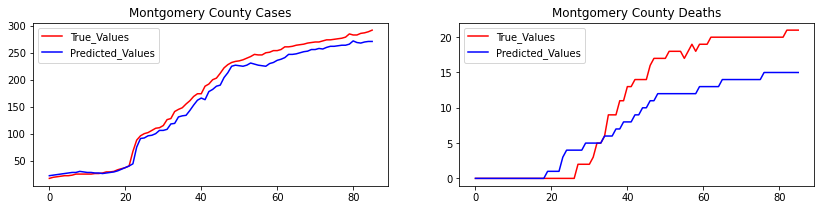

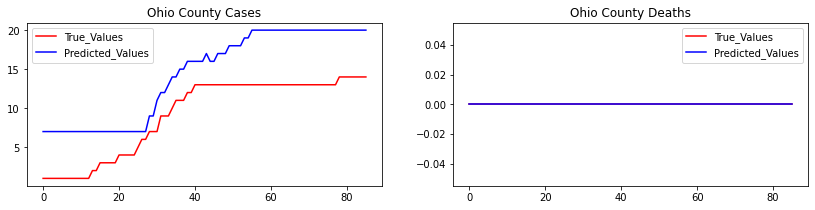

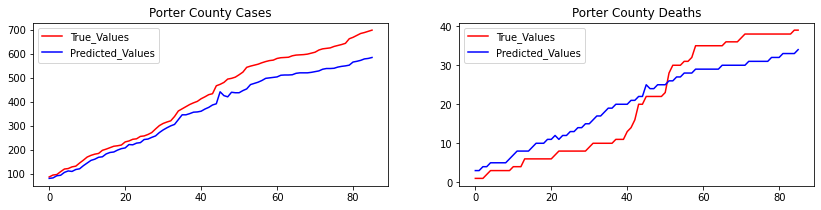

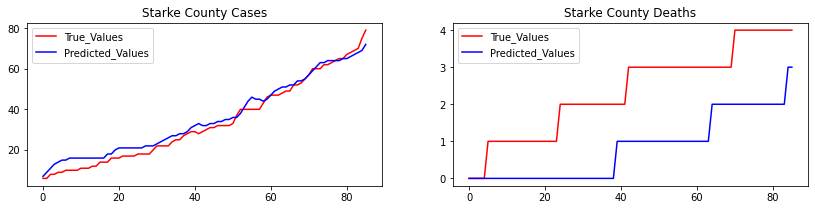

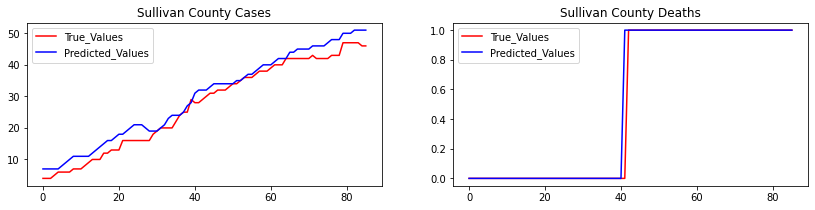

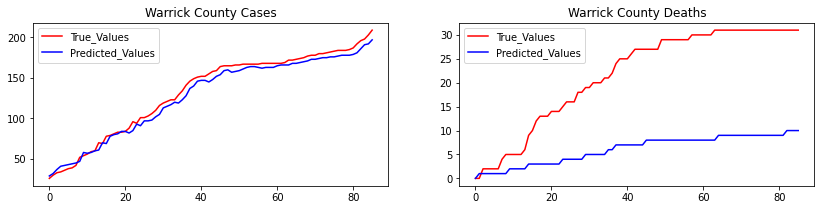

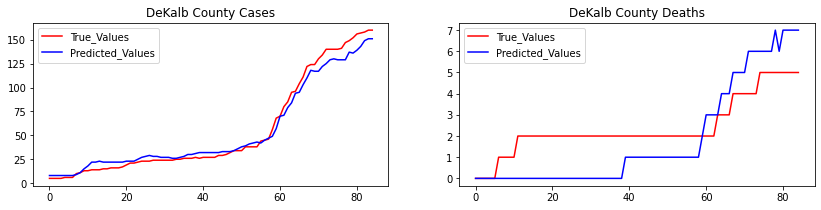

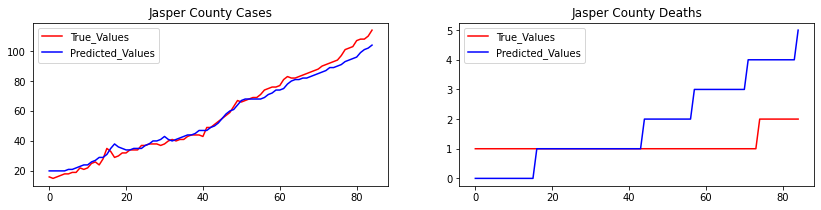

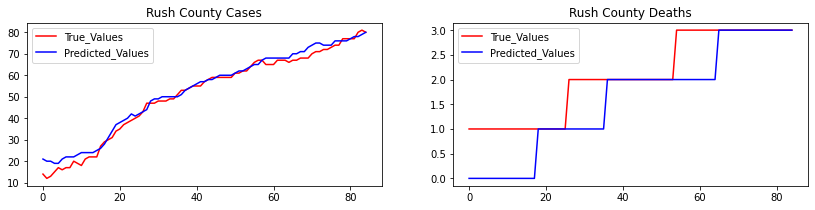

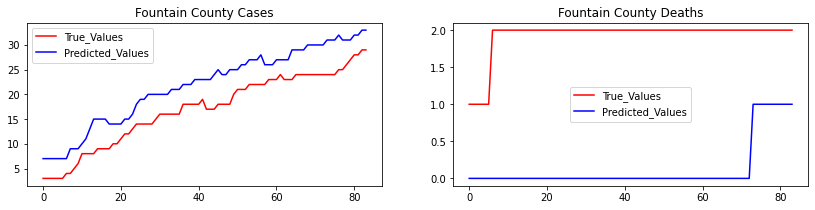

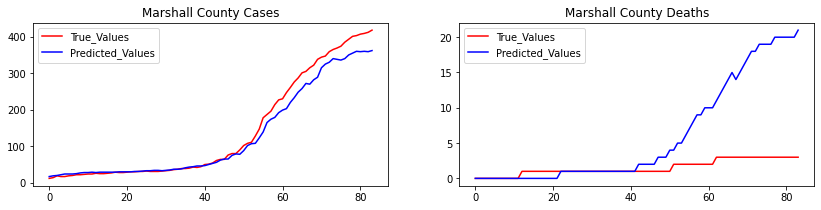

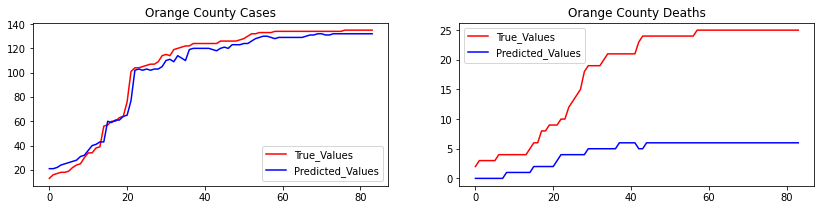

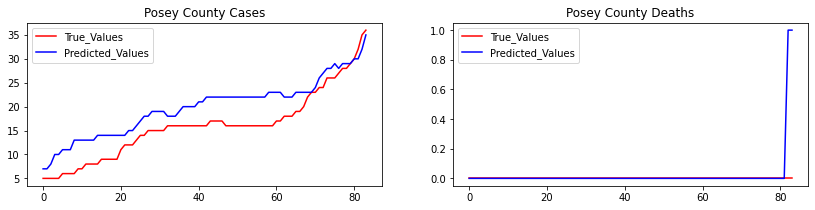

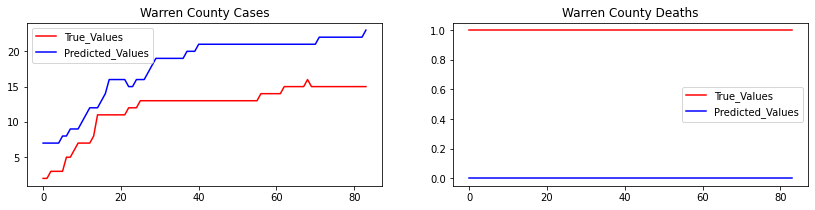

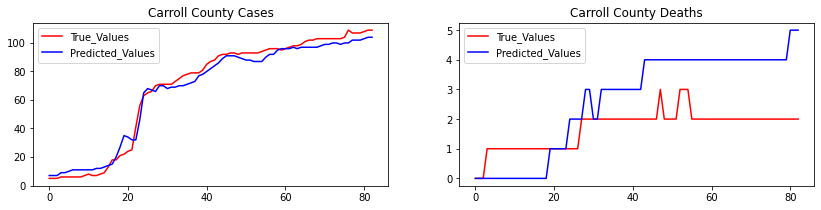

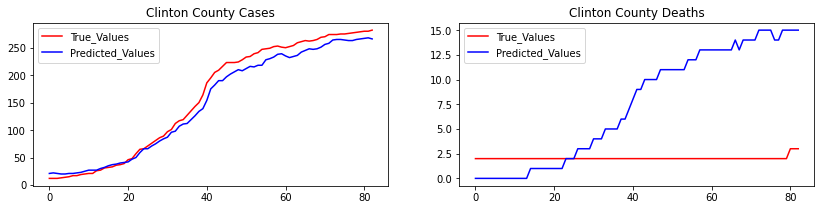

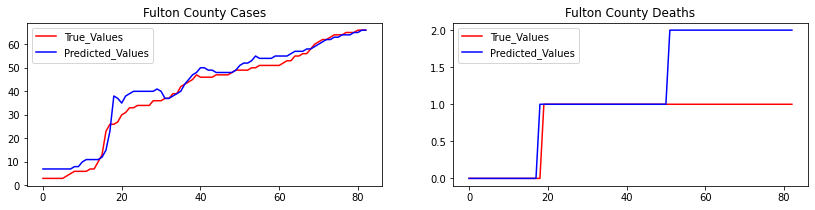

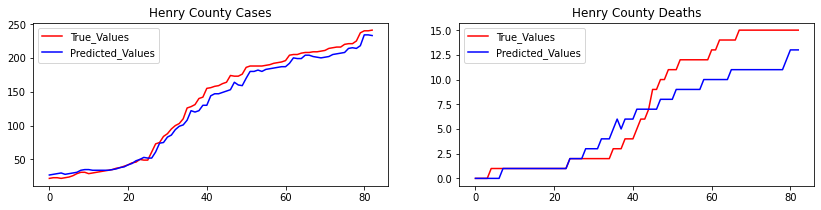

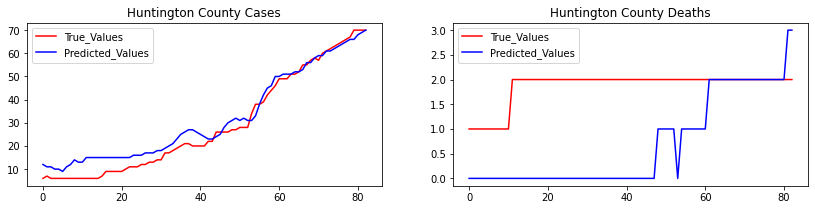

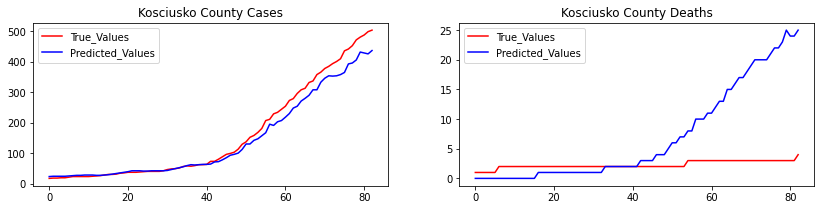

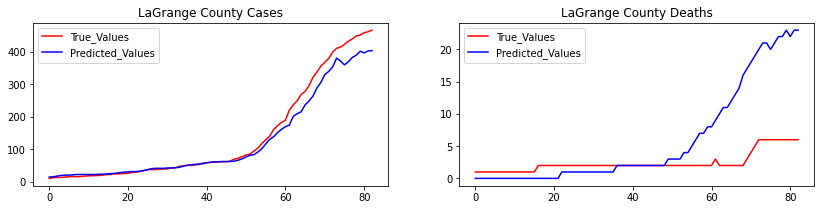

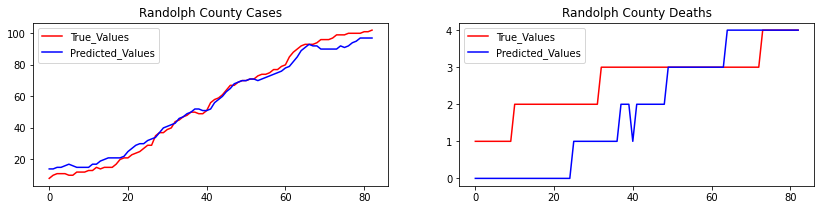

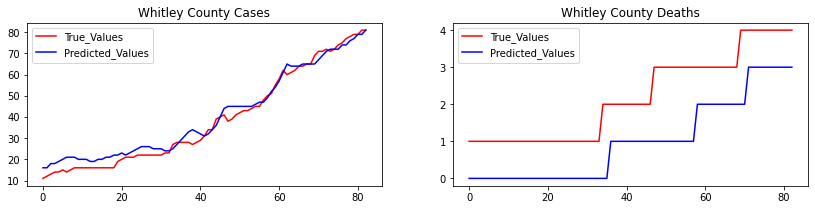

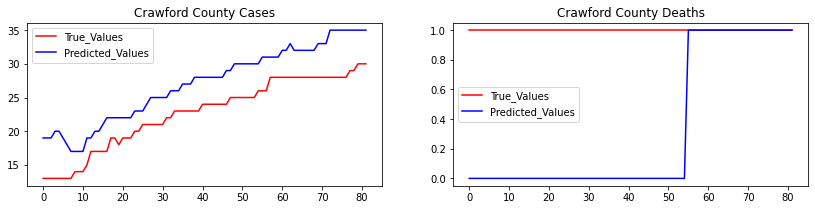

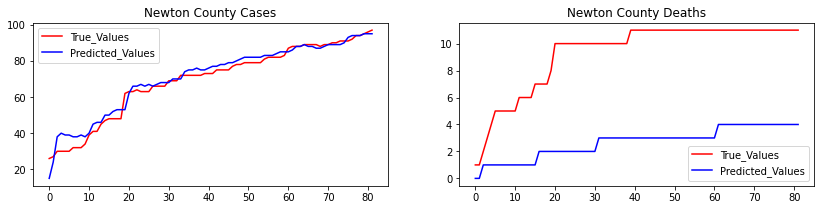

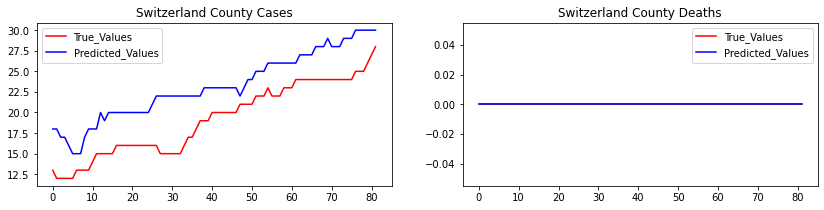

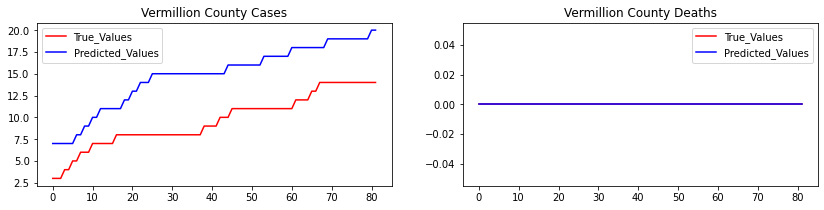

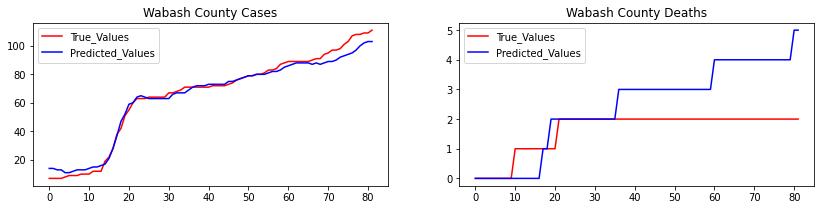

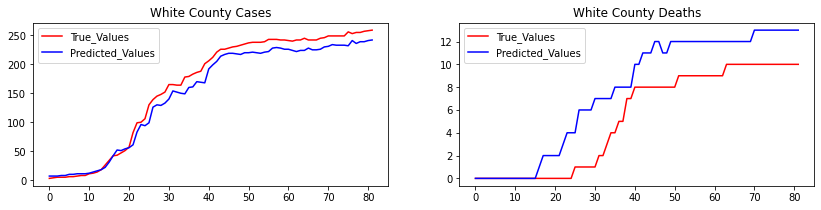

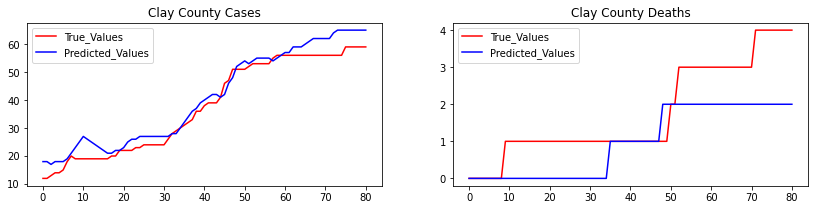

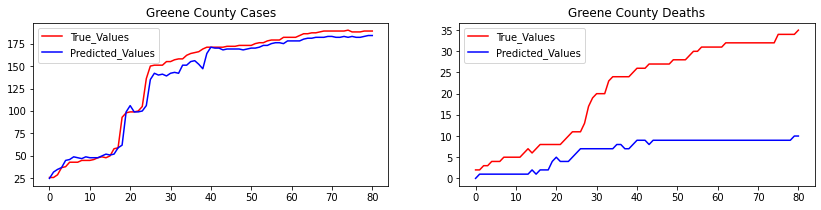

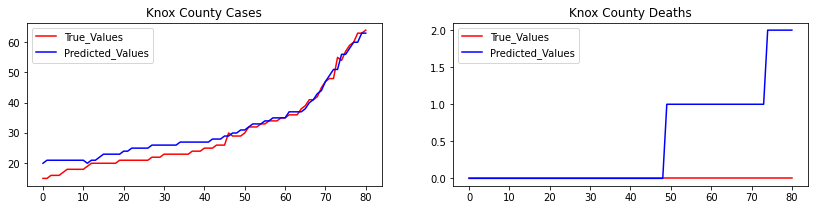

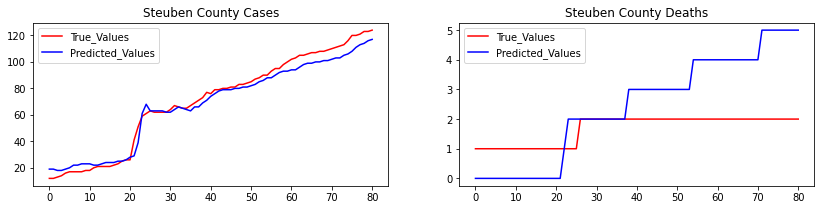

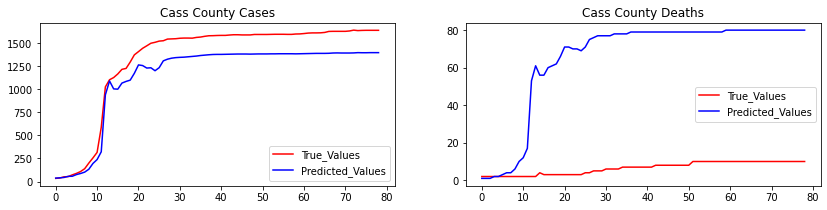

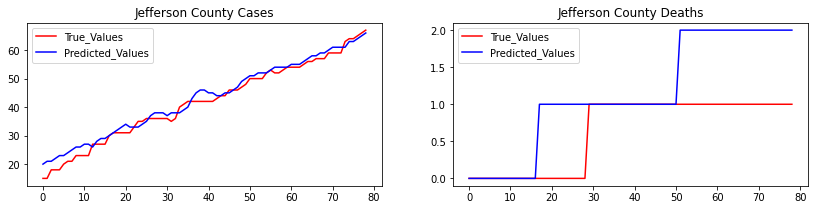

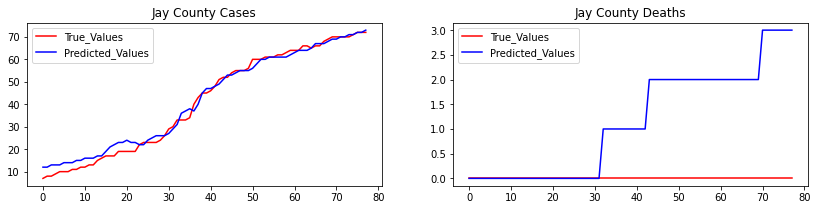

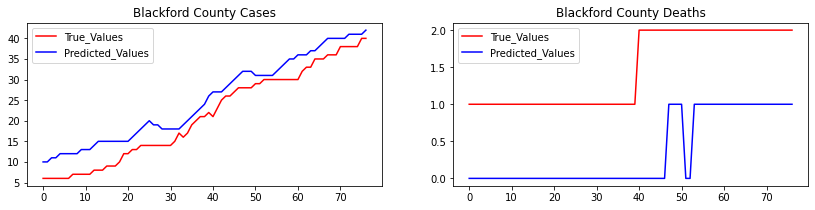

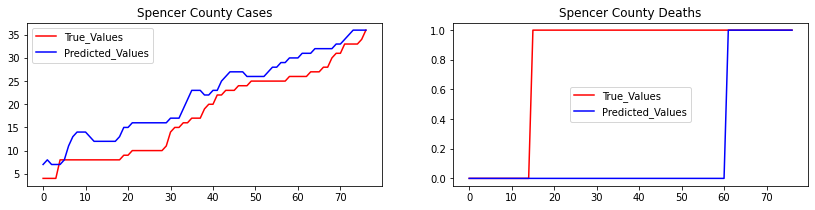

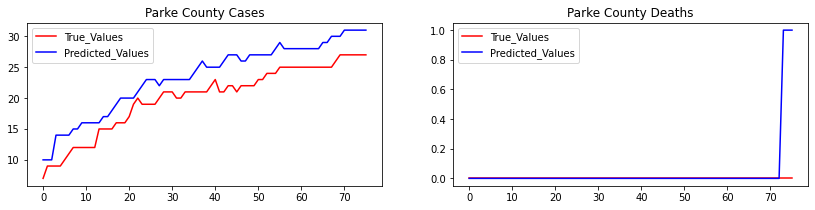

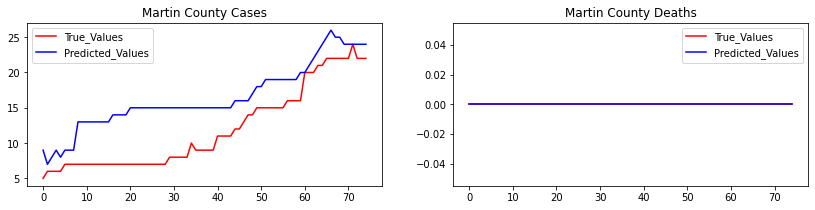

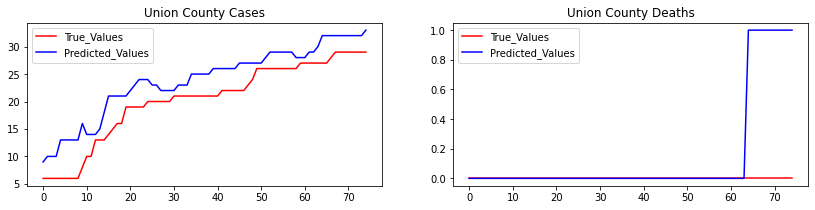

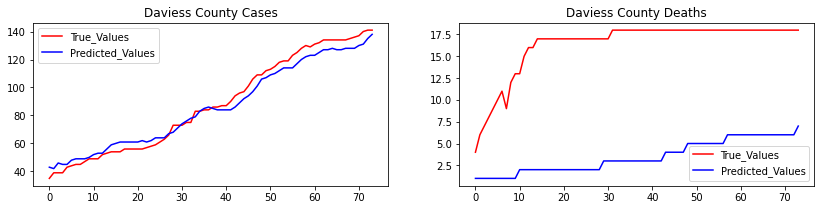

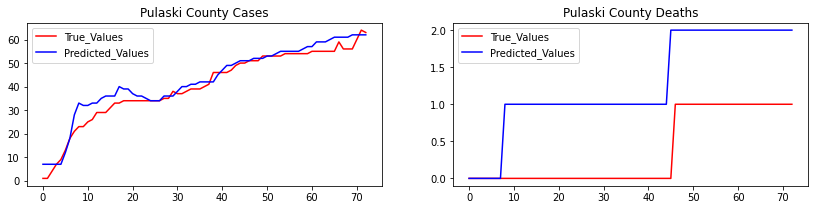

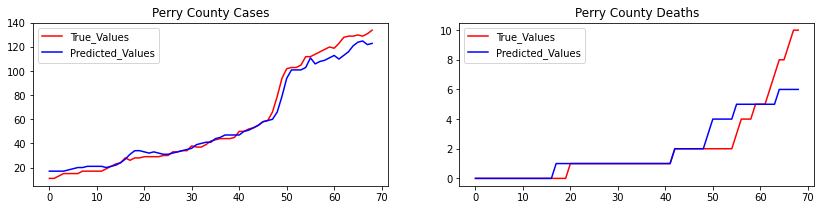

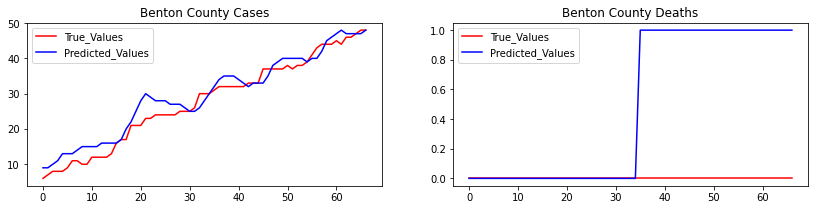

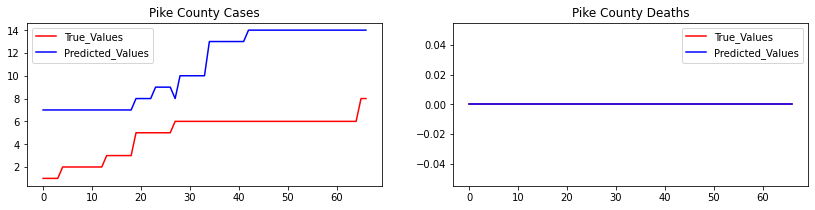

In [ ]:
n_len = 15
counties = df['county'].unique()

for county in counties[:]:
  df3 = df[df['county']==county]
  if df3.shape[0]<80:
    continue
  df3 = df3[['cases', 'deaths']]
  #df3 = df3.diff(periods=1)
  df3 = df3.iloc[:,:].values
  testX, testY = processValData(df3, n_len)
  #print(testX.shape, testY.shape)
  predictedValues = new_regressor.predict(testX)
  for i in range(predictedValues.shape[0]):
    for j in range(predictedValues.shape[1]):
      predictedValues[i,j] = int(predictedValues[i,j])
  #print(predictedValues)
  #print(predictedValues.shape==testY.shape)


  # plt.plot(testY[:,0],color = 'red', label = 'True_Values')
  # plt.plot(predictedValues[:,0], color = 'blue', label = 'Predicted_Values')
  # plt.title(county)
  # plt.xlabel('Time')
  # plt.ylabel('COVID Cases')
  # plt.legend()
  # plt.show()

  # plt.plot(testY[:,1],color = 'red', label = 'True_Values')
  # plt.plot(predictedValues[:,1], color = 'blue', label = 'Predicted_Values')
  # plt.title(county)
  # plt.xlabel('Time')
  # plt.ylabel('COVID Deaths')
  # plt.legend()
  # plt.show()

  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,3))
  ax1.plot(testY[:,0],color = 'red', label = 'True_Values')
  ax1.plot(predictedValues[:,0], color = 'blue', label = 'Predicted_Values')
  ax1.set_title(county + ' County Cases')
  ax1.legend()
  ax2.plot(testY[:,1],color = 'red', label = 'True_Values')
  ax2.plot(predictedValues[:,1], color = 'blue', label = 'Predicted_Values')
  ax2.set_title(county + ' County Deaths')
  ax2.legend()

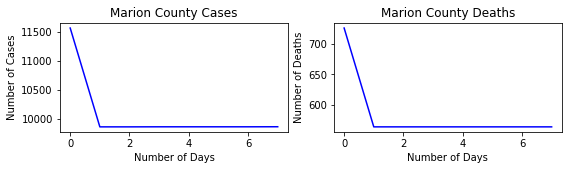

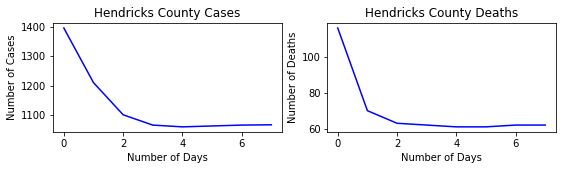

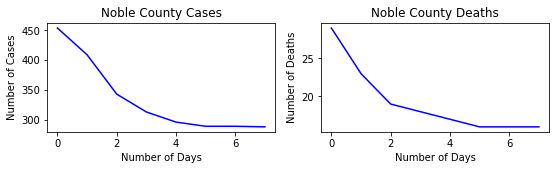

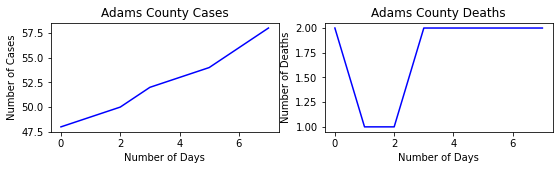

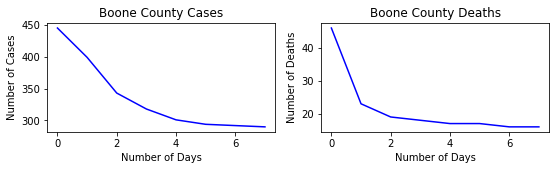

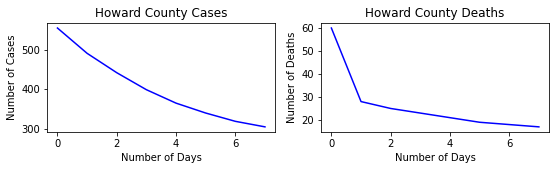

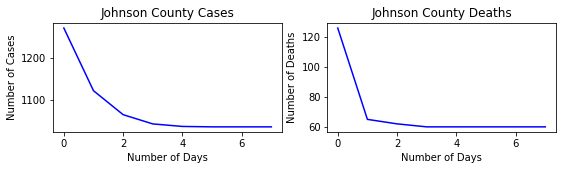

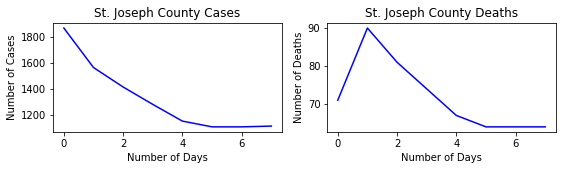

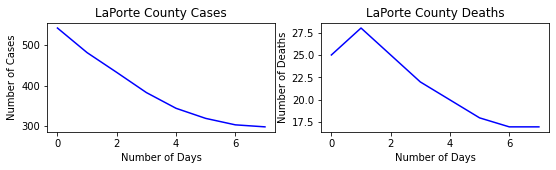

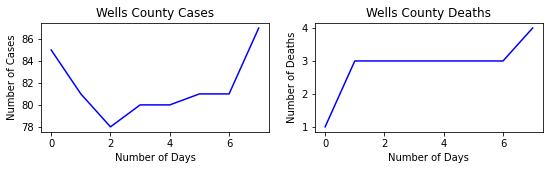

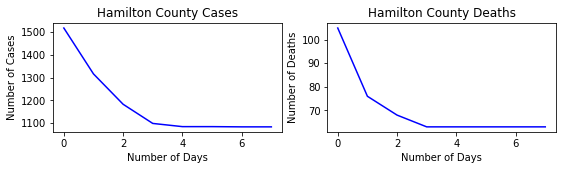

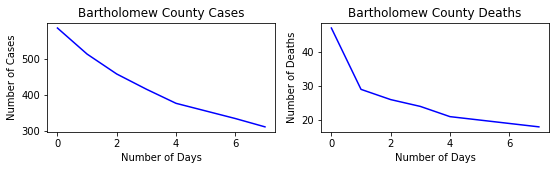

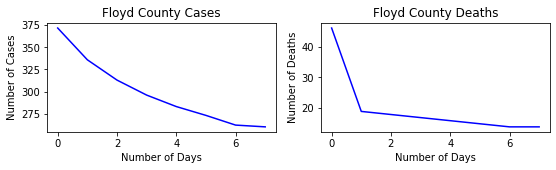

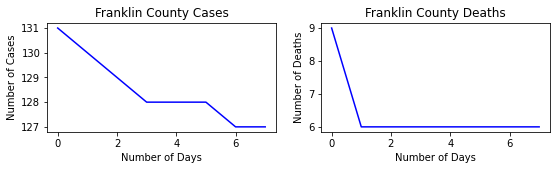

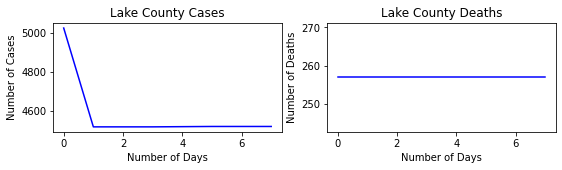

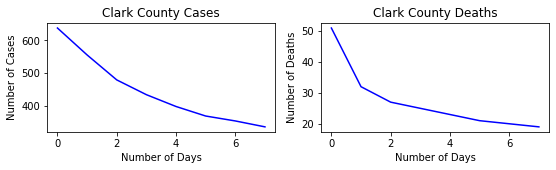

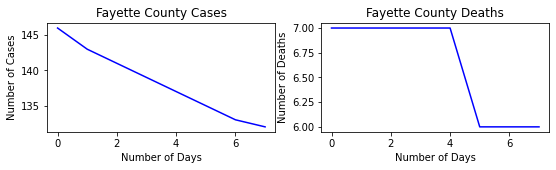

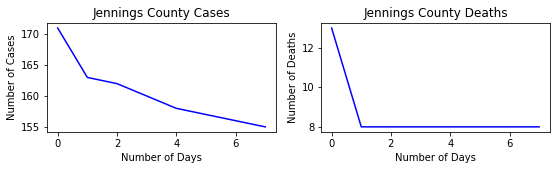

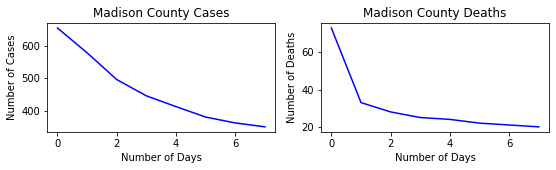

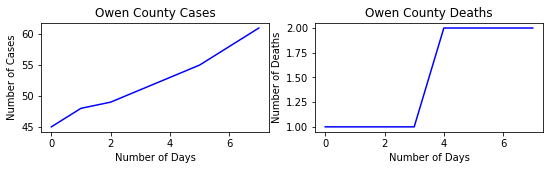

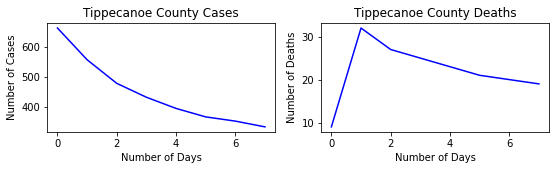

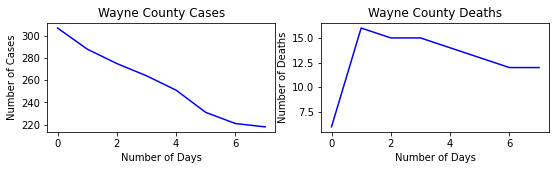

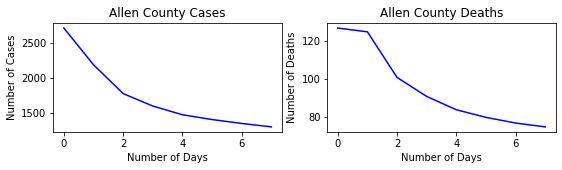

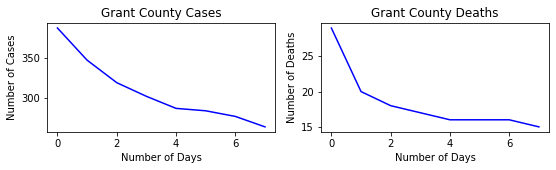

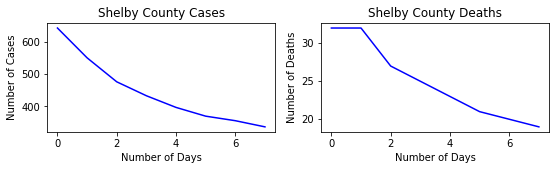

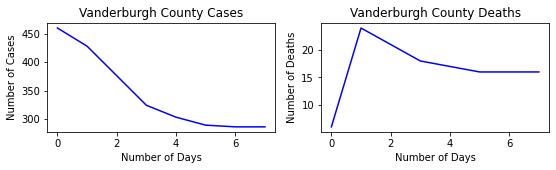

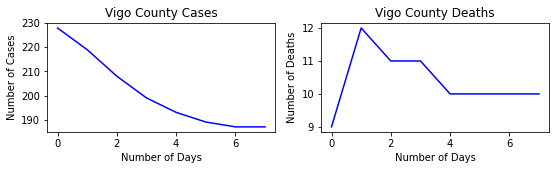

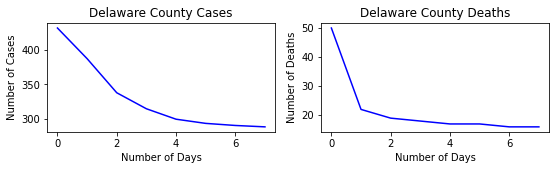

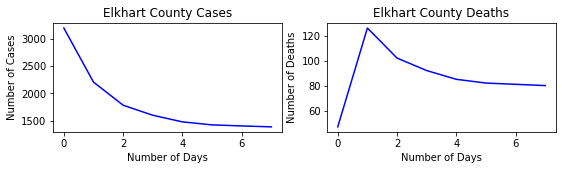

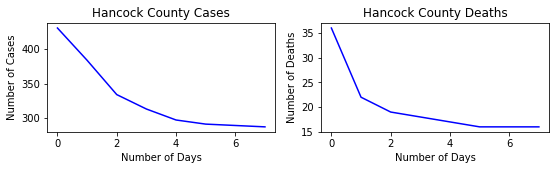

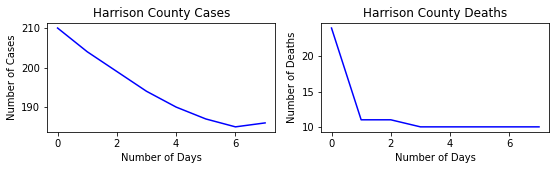

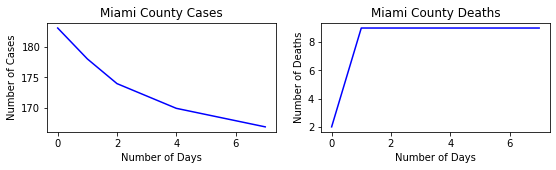

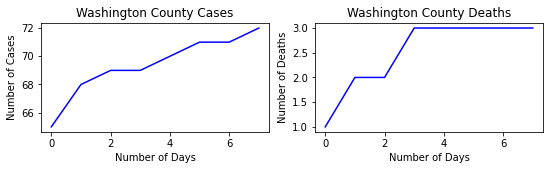

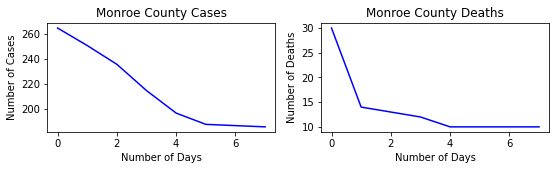

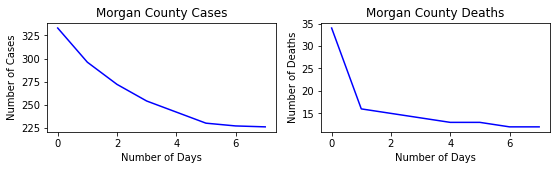

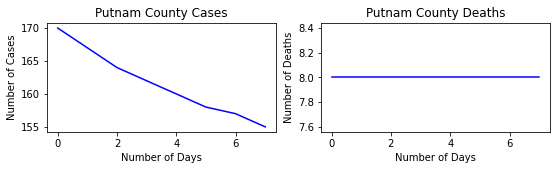

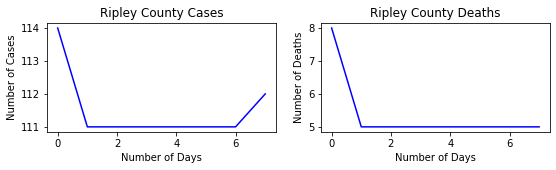

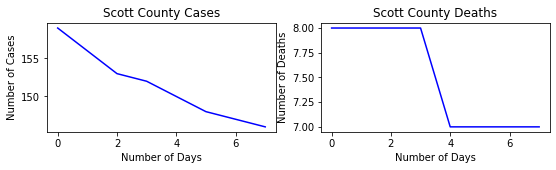

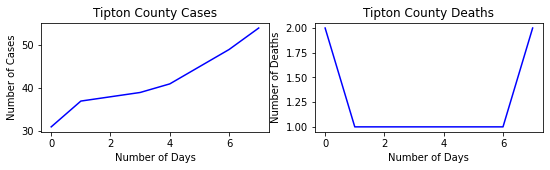

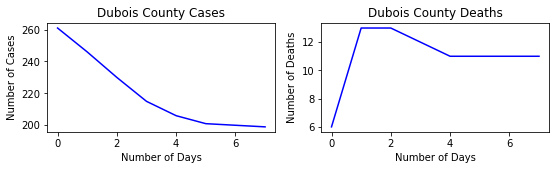

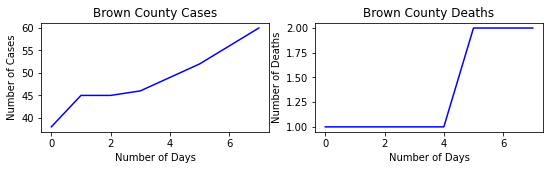

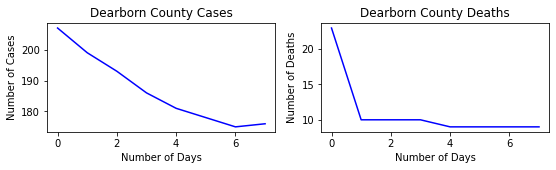

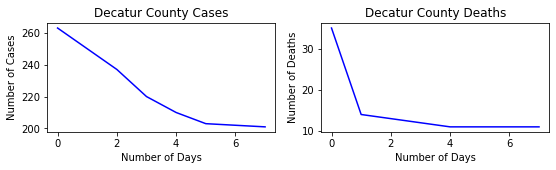

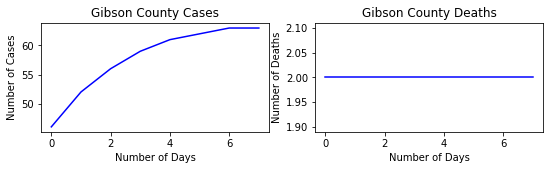

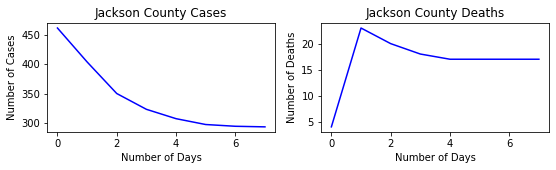

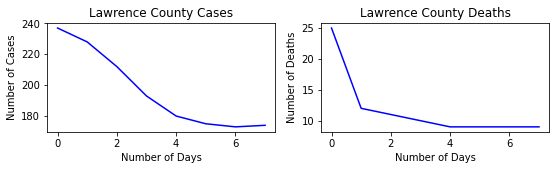

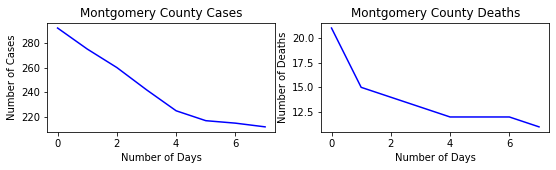

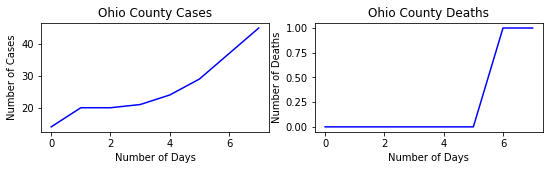

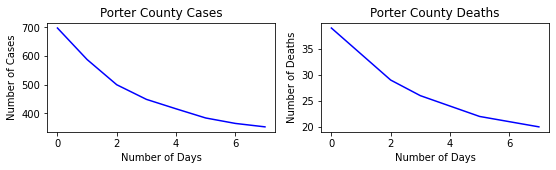

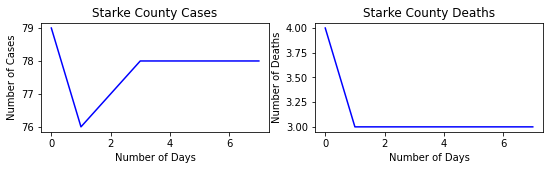

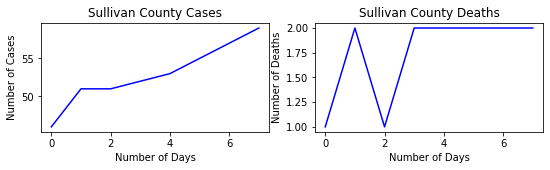

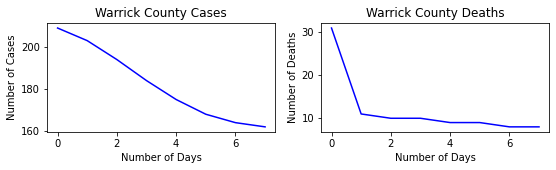

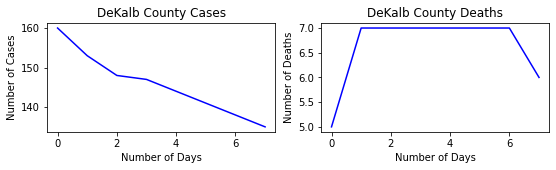

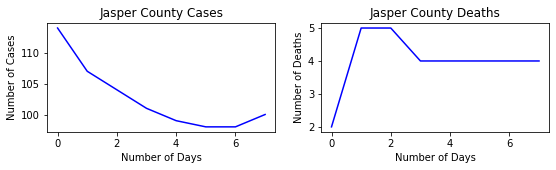

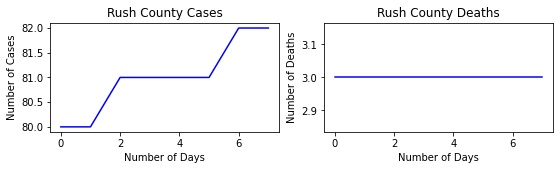

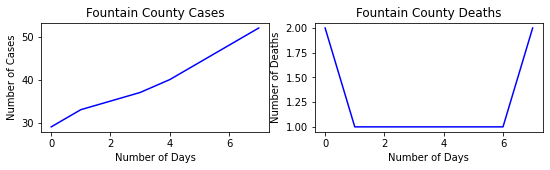

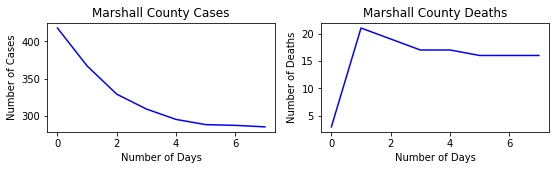

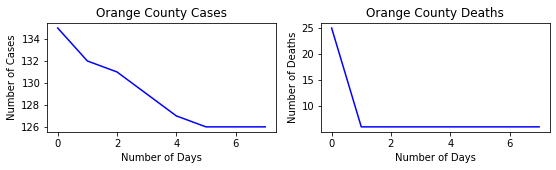

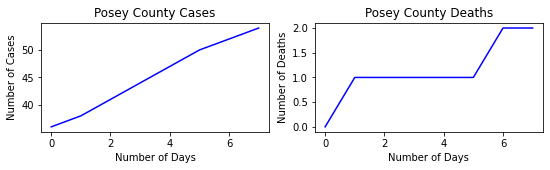

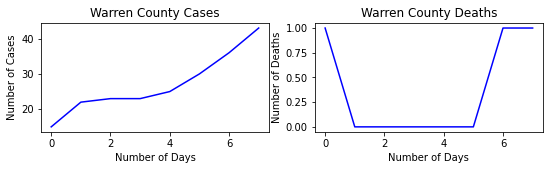

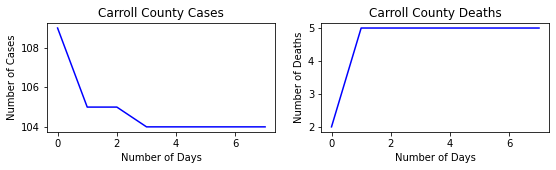

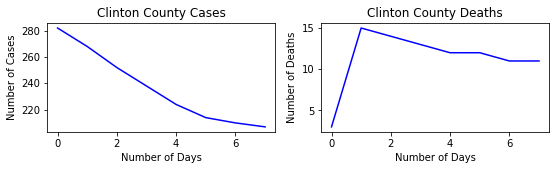

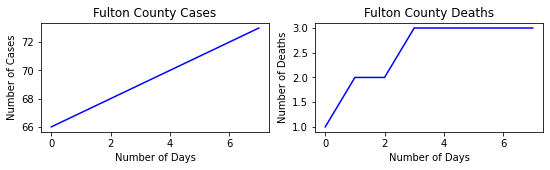

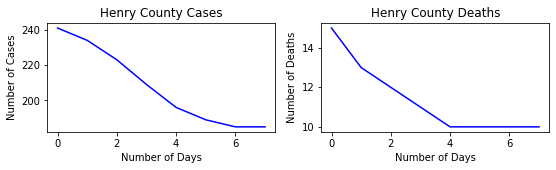

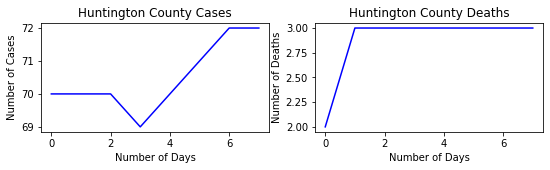

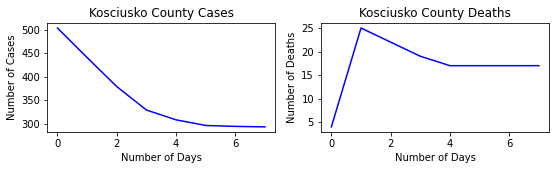

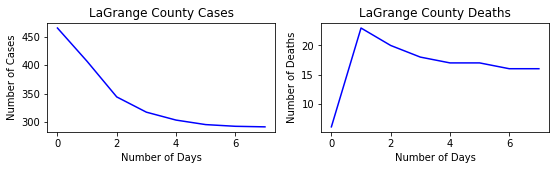

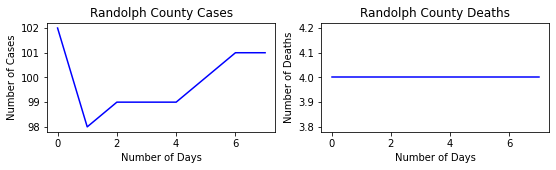

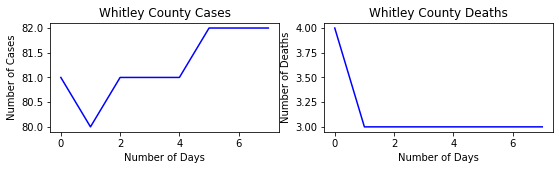

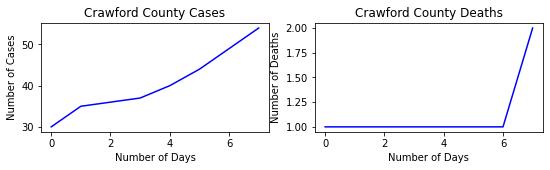

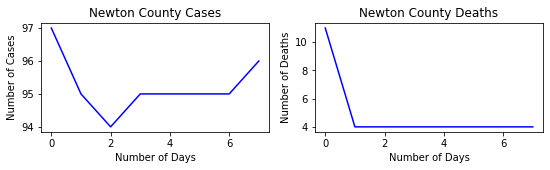

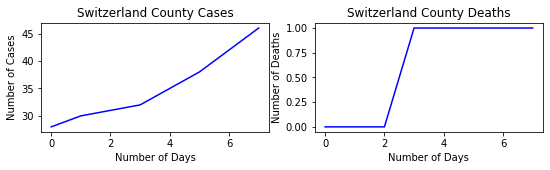

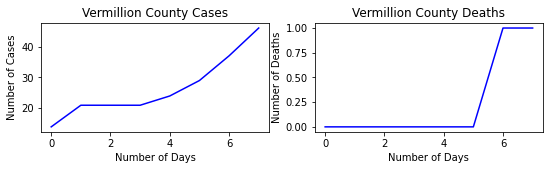

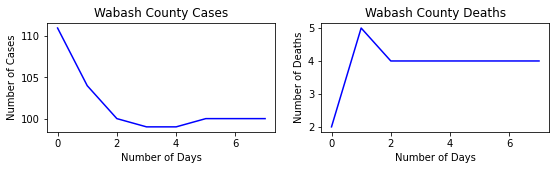

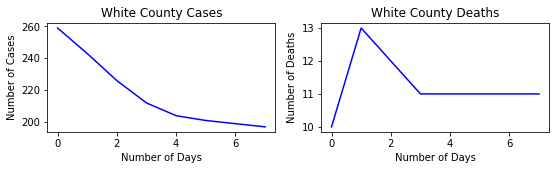

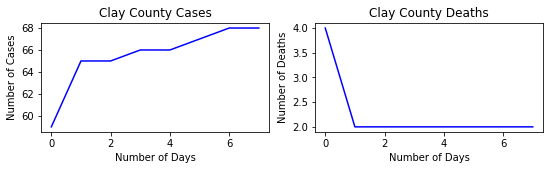

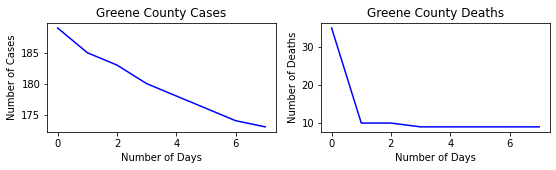

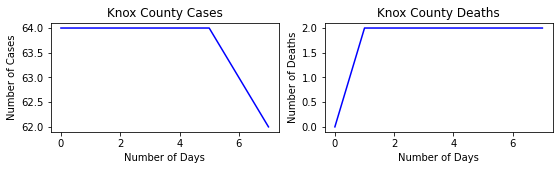

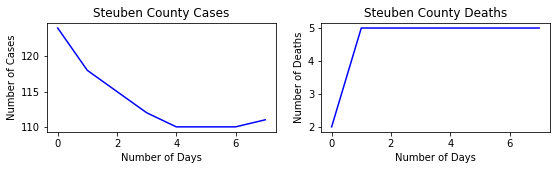

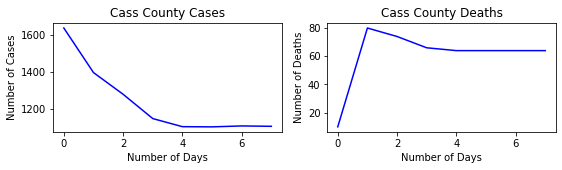

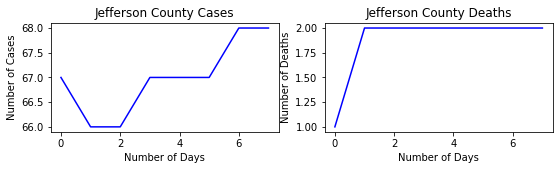

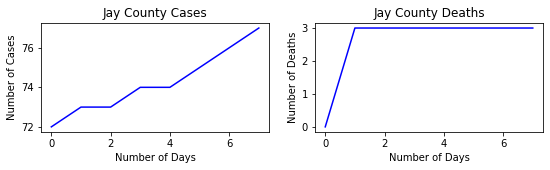

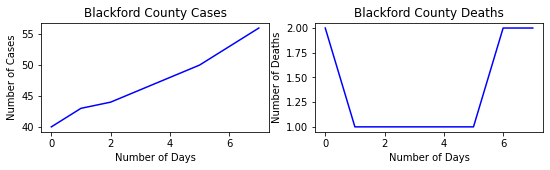

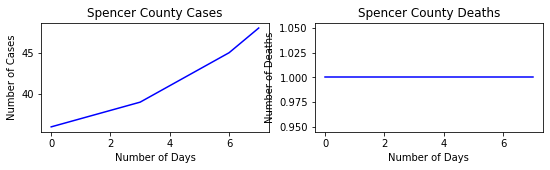

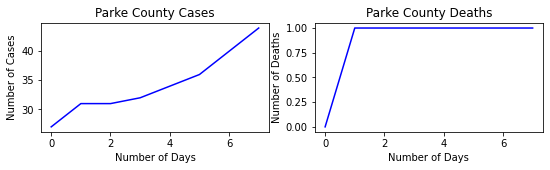

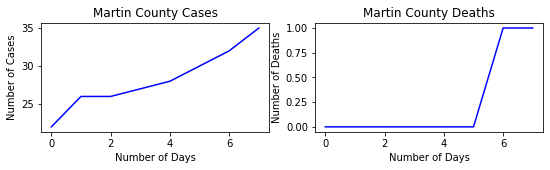

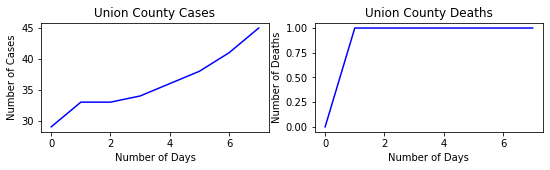

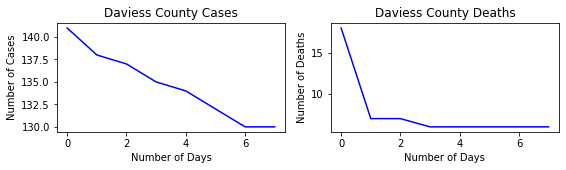

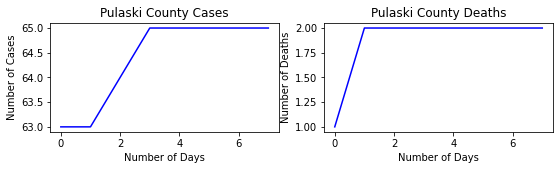

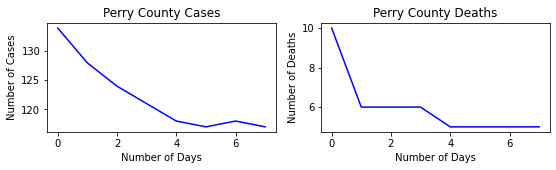

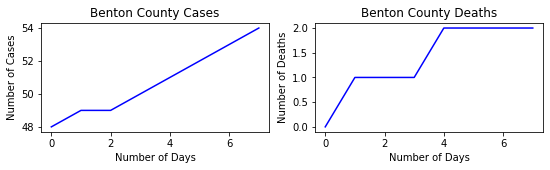

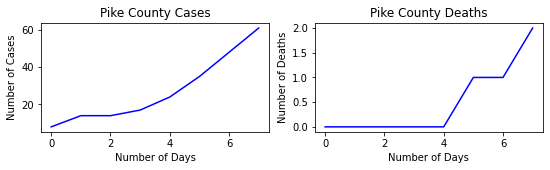

In [ ]:
def Forecast(df, numOfDays = 7, n_len = 15):
  counties = df['county'].unique()
  for county in counties:
    df5 = df[df['county']==county]
    df5 = df5.iloc[-n_len:,:]
    if df5.shape[0]<15:
      continue
    #print(county, df5.shape)
    df6 = df5[['cases', 'deaths']].values.reshape(1,15,2)

    for i in range(numOfDays):
      predictedValues = new_regressor.predict(df6[:,-15:, :])
      for j in range(predictedValues.shape[0]):
        for k in range(predictedValues.shape[1]):
          predictedValues[j,k] = int(predictedValues[j,k])
      df6 = np.concatenate((df6, predictedValues.reshape(1,1,2)), axis = 1)
      #print(df6.shape)
    #print(df6)
    df6 = df6.reshape(df6.shape[1], df6.shape[2])
    #print(df6.shape)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,2))
    ax1.plot(df6[-(numOfDays+1):,0], color = 'blue')
    ax1.set_title(county + ' County Cases')
    ax1.set_xlabel('Number of Days')
    ax1.set_ylabel('Number of Cases')
    ax2.plot(df6[-(numOfDays+1):,1], color = 'blue')
    ax2.set_title(county + ' County Deaths')
    ax2.set_xlabel('Number of Days')
    ax2.set_ylabel('Number of Deaths')


Forecast(df)

Indy State Analysis

In [4]:
url = 'https://github.com/nytimes/covid-19-data/blob/master/us-states.csv?raw=true'

df = pd.read_csv(url)
columnsToKeep = ['date', 'state', 'cases', 'deaths']
df = df[columnsToKeep]
df

date          state  cases  deaths
0     2020-01-21     Washington      1       0
1     2020-01-22     Washington      1       0
2     2020-01-23     Washington      1       0
3     2020-01-24       Illinois      1       0
4     2020-01-24     Washington      1       0
...          ...            ...    ...     ...
6774  2020-07-03       Virginia  64393    1845
6775  2020-07-03     Washington  36417    1353
6776  2020-07-03  West Virginia   3126      93
6777  2020-07-03      Wisconsin  33565     804
6778  2020-07-03        Wyoming   1582      20

[6779 rows x 4 columns]

In [57]:
states = df['state'].unique()
for state in states:
    dfTemp = df[df['state']==state]
    print(state, dfTemp.shape)

Washington (165, 4)
Illinois (162, 4)
California (161, 4)
Arizona (160, 4)
Massachusetts (154, 4)
Wisconsin (150, 4)
Texas (143, 4)
Nebraska (138, 4)
Utah (130, 4)
Oregon (127, 4)
Florida (125, 4)
New York (125, 4)
Rhode Island (125, 4)
Georgia (124, 4)
New Hampshire (124, 4)
North Carolina (123, 4)
New Jersey (122, 4)
Colorado (121, 4)
Maryland (121, 4)
Nevada (121, 4)
Tennessee (121, 4)
Hawaii (120, 4)
Indiana (120, 4)
Kentucky (120, 4)
Minnesota (120, 4)
Oklahoma (120, 4)
Pennsylvania (120, 4)
South Carolina (120, 4)
District of Columbia (119, 4)
Kansas (119, 4)
Missouri (119, 4)
Vermont (119, 4)
Virginia (119, 4)
Connecticut (118, 4)
Iowa (118, 4)
Louisiana (117, 4)
Ohio (117, 4)
Michigan (116, 4)
South Dakota (116, 4)
Arkansas (115, 4)
Delaware (115, 4)
Mississippi (115, 4)
New Mexico (115, 4)
North Dakota (115, 4)
Wyoming (115, 4)
Alaska (114, 4)
Maine (114, 4)
Alabama (113, 4)
Idaho (113, 4)
Montana (113, 4)
Puerto Rico (113, 4)
Virgin Islands (112, 4)
Guam (111, 4)
West Virgini

In [135]:
def windowData(training_scaled, n_len):
  x_train = []
  y_train = []
  for i in range(n_len,training_scaled.shape[0]):
    x_train.append(training_scaled[i-n_len:i, :])
    y_train.append(training_scaled[i,:])

  x_train,y_train = np.array(x_train),np.array(y_train)
  #print(x_train.shape, y_train.shape)
  return x_train,y_train

def processData(df, n_len = 15):
  states = df['state'].unique()
  trainX = np.random.randn(1,n_len, 2)
  trainY = np.random.randn(1,2)
  #print(trainX, trainY)
  tempX = []
  tempY = []
  for state in states[:15]:
    #print(state)
    df1 = df[df['state']==state]
    if df1.shape[0]<105:
      continue
    df2 = df1[['cases', 'deaths']]
    #df2 = df2.diff(periods=1)
    #print(df2)
    df2 = df2.values
    tempX, tempY = windowData(df2, n_len)
    trainX = np.concatenate((trainX, tempX), axis = 0)
    trainY = np.concatenate((trainY, tempY), axis = 0)

  trainX , trainY = trainX[1:,:,:] ,  trainY[1:,:]
  return trainX , trainY

trainX , trainY = processData(df, 15)
print("After Preprocessing the data")
print(trainX.shape, trainY.shape)
batchSize = 128

After Preprocessing the data
(1888, 15, 2) (1888, 2)


In [136]:
clear_session()

model_indy = Sequential()
model_indy.add(GRU(units = batchSize,return_sequences = True,input_shape = (trainX.shape[1],trainX.shape[2])))
# model_indy.add(GRU(units = 2000,return_sequences = True))
model_indy.add(GRU(units = 300,return_sequences = True))
model_indy.add(GRU(units = 250,return_sequences = False))
# model_indy.add(Dense(units = 4096, activation = 'relu'))
# model_indy.add(Dropout(0.15))
# model_indy.add(Dense(units = 2048, activation = 'relu'))
# model_indy.add(Dropout(0.15))
# model_indy.add(Dense(units = 1024, activation = 'relu'))
# model_indy.add(Dropout(0.1))
model_indy.add(Dense(units = 124, activation = 'relu'))
model_indy.add(Dropout(0.05))
model_indy.add(Dense(units = 2))

model_indy.compile(optimizer = 'adam',loss = 'mean_absolute_error')
model_indy.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 15, 128)           50688     
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 300)           387000    
_________________________________________________________________
gru_2 (GRU)                  (None, 250)               414000    
_________________________________________________________________
dense (Dense)                (None, 124)               31124     
_________________________________________________________________
dropout (Dropout)            (None, 124)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 250       
Total params: 883,062
Trainable params: 883,062
Non-trainable params: 0
__________________________________________________

In [139]:
model_indy.fit(trainX,trainY,epochs = 25, batch_size = batchSize)
#new_indyModel.fit(trainX,trainY,epochs = 5, batch_size = batchSize)

Epoch 1/25
15/15 [==============================] - 0s 8ms/step - loss: 17170.4922
Epoch 2/25
15/15 [==============================] - 0s 8ms/step - loss: 15802.2432
Epoch 3/25
15/15 [==============================] - 0s 8ms/step - loss: 15252.0352
Epoch 4/25
15/15 [==============================] - 0s 8ms/step - loss: 15886.2461
Epoch 5/25
15/15 [==============================] - 0s 8ms/step - loss: 17080.7461
Epoch 6/25
15/15 [==============================] - 0s 8ms/step - loss: 15686.6387
Epoch 7/25
15/15 [==============================] - 0s 8ms/step - loss: 15469.1318
Epoch 8/25
15/15 [==============================] - 0s 8ms/step - loss: 16377.1904
Epoch 9/25
15/15 [==============================] - 0s 8ms/step - loss: 16008.5859
Epoch 10/25
15/15 [==============================] - 0s 8ms/step - loss: 17642.2812
Epoch 11/25
15/15 [==============================] - 0s 8ms/step - loss: 18797.1836
Epoch 12/25
15/15 [==============================] - 0s 8ms/step - loss: 18049.4277
E

In [140]:
path = f"{os.getcwd()}/drive/My Drive/Techpoint/indyModel.h5"
model_indy.save(path) 
#new_indyModel.save(path)

In [141]:
path = f"{os.getcwd()}/drive/My Drive/Techpoint/indyModel.h5"
new_indyModel= load_model(path)

In [142]:
def processValData(training_scaled, n_len = 15):
  x_train = []
  y_train = []
  for i in range(n_len,len(training_scaled)):
      x_train.append(training_scaled[i-n_len:i, :])
      y_train.append(training_scaled[i,:])

  x_train,y_train = np.array(x_train),np.array(y_train)
  return x_train,y_train

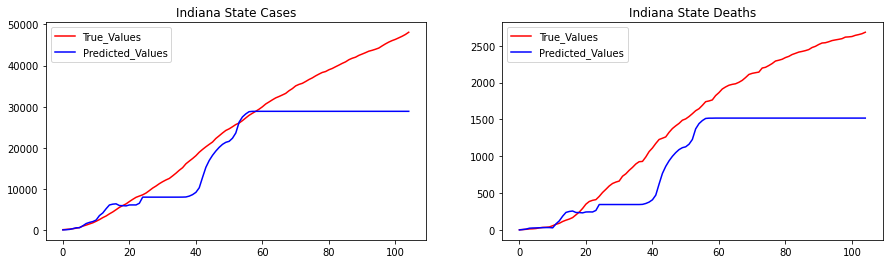

In [143]:
df3 = df[df['state']=='Indiana']
# if df3.shape[0]<80:
#     continue
df3 = df3[['cases', 'deaths']]
df3 = df3.iloc[:,:].values
testX, testY = processValData(df3, 15)
predictedValues = new_indyModel.predict(testX)

for i in range(predictedValues.shape[0]):
  for j in range(predictedValues.shape[1]):
    predictedValues[i,j] = int(predictedValues[i,j])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.plot(testY[:,0],color = 'red', label = 'True_Values')
ax1.plot(predictedValues[:,0], color = 'blue', label = 'Predicted_Values')
ax1.set_title('Indiana State Cases')
ax1.legend()
ax2.plot(testY[:,1],color = 'red', label = 'True_Values')
ax2.plot(predictedValues[:,1], color = 'blue', label = 'Predicted_Values')
ax2.set_title('Indiana State Deaths')
ax2.legend()

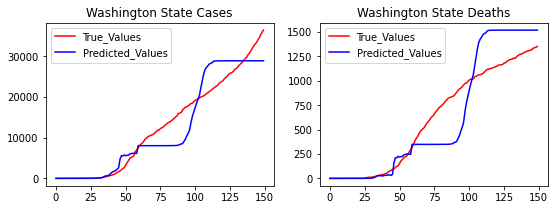

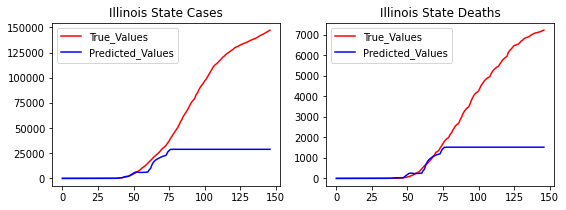

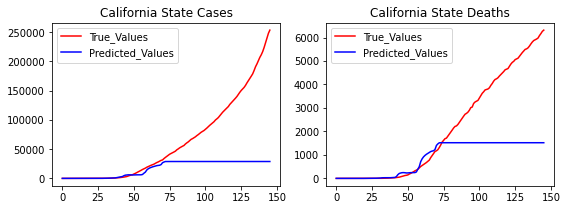

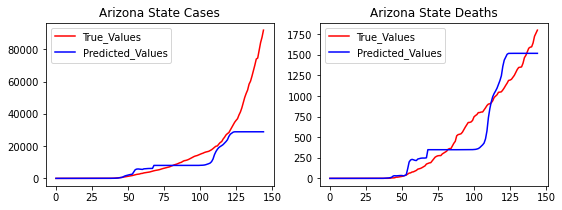

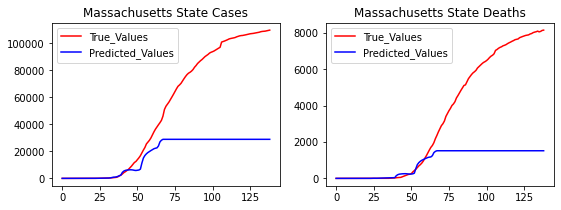

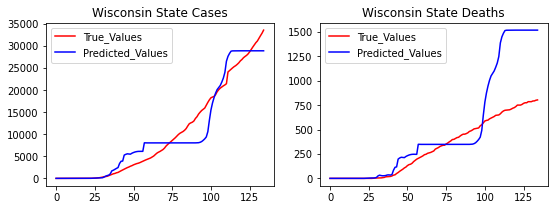

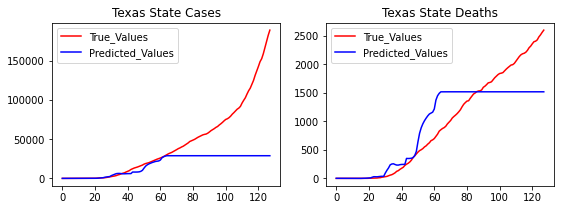

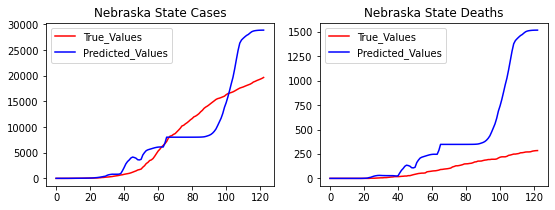

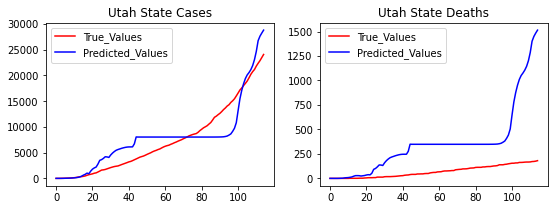

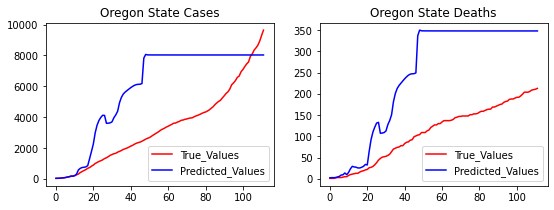

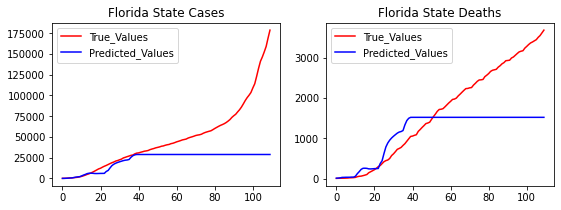

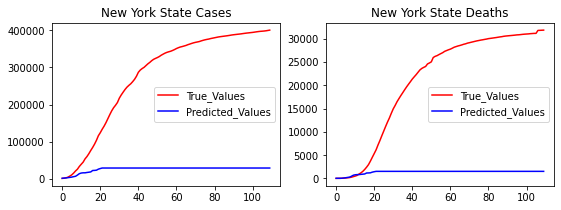

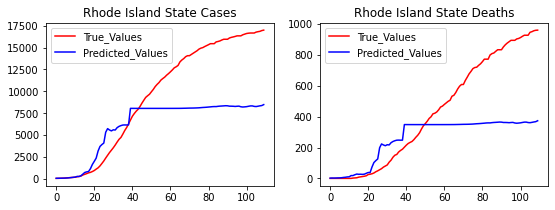

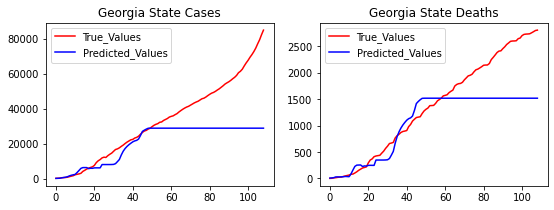

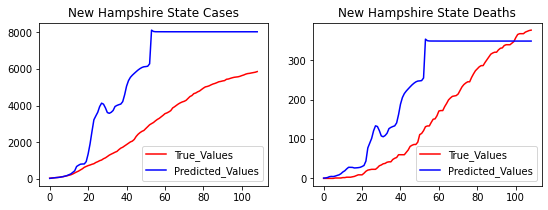

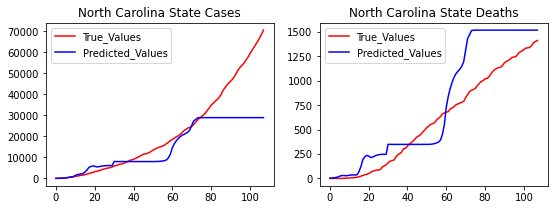

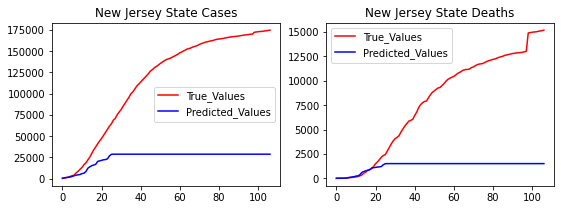

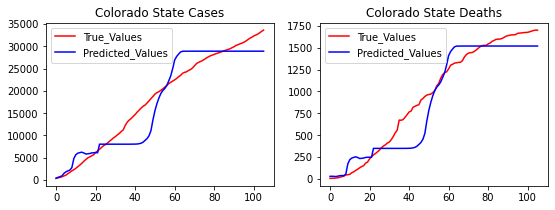

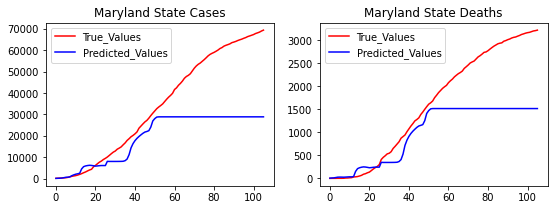

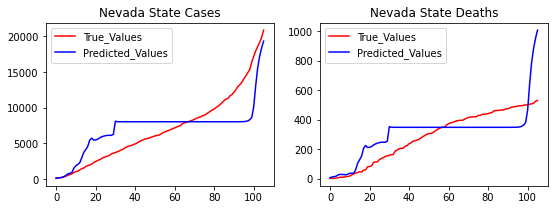

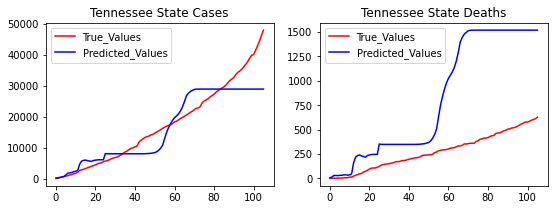

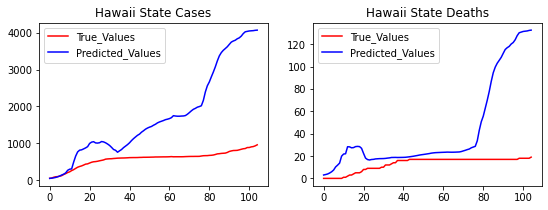

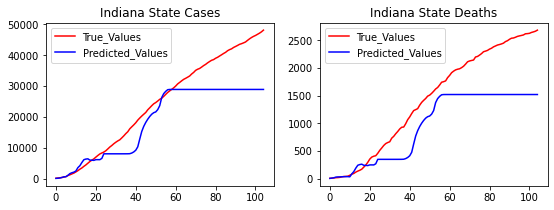

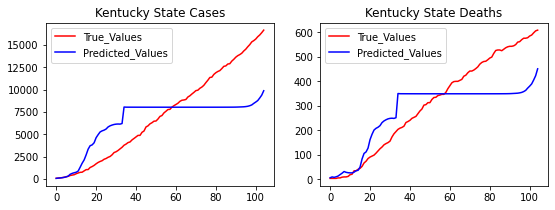

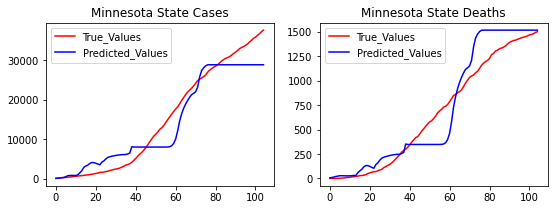

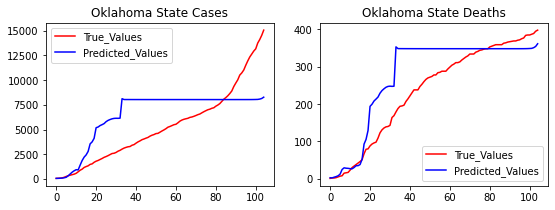

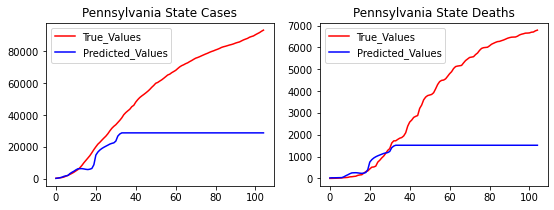

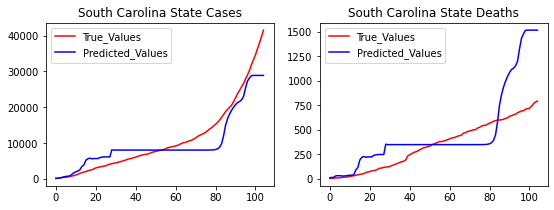

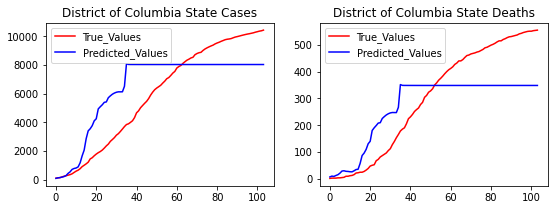

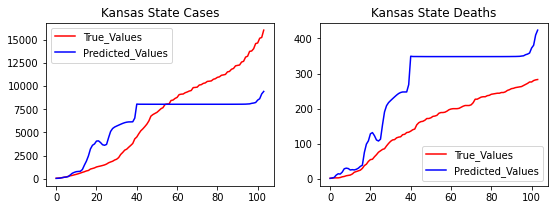

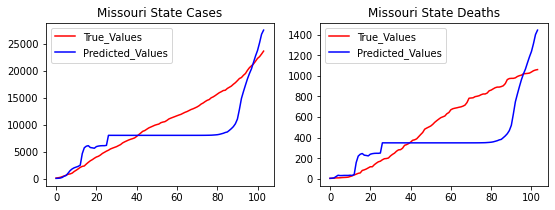

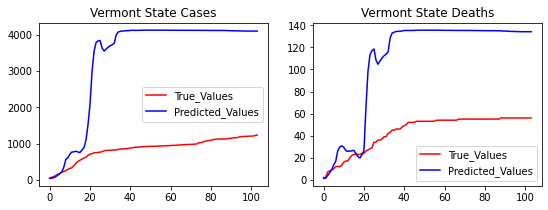

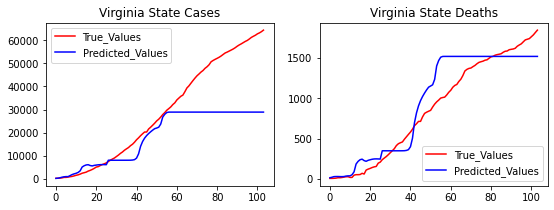

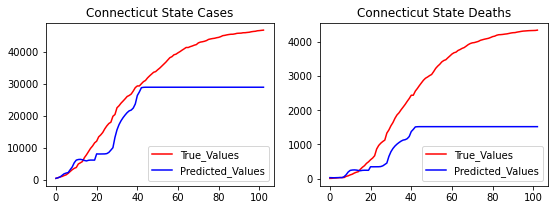

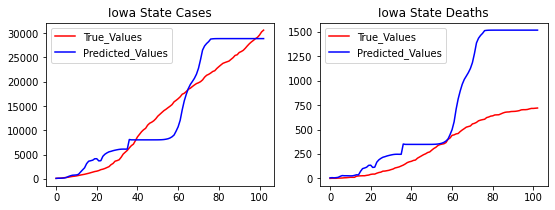

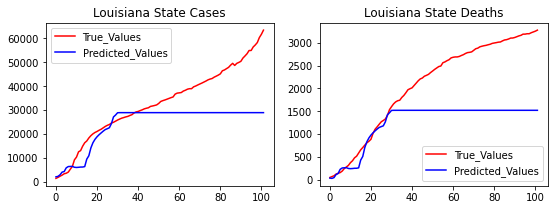

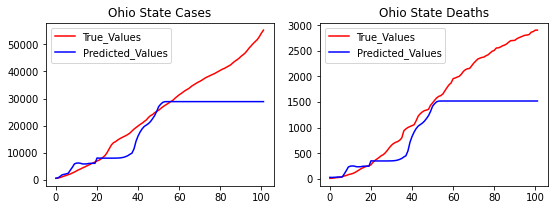

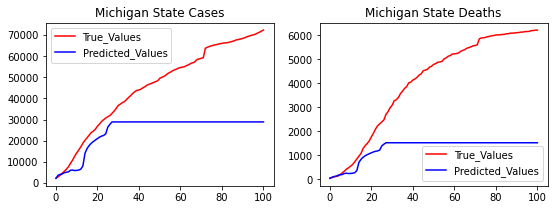

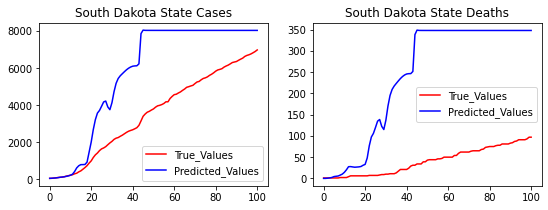

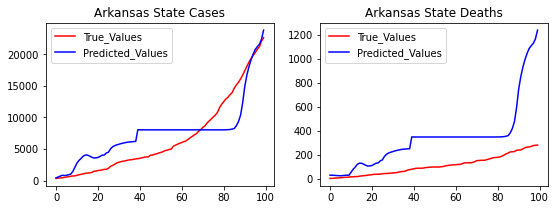

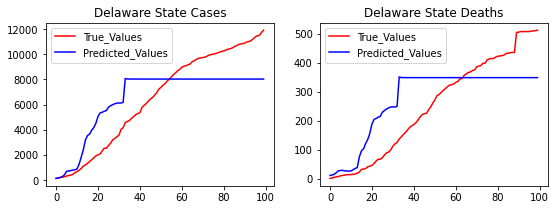

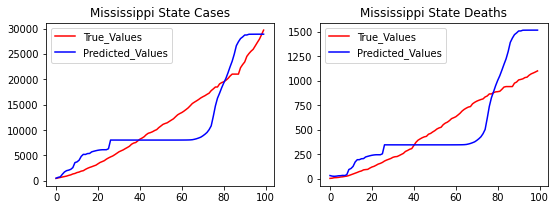

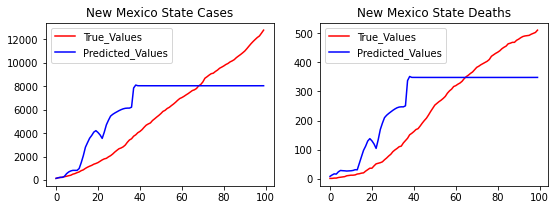

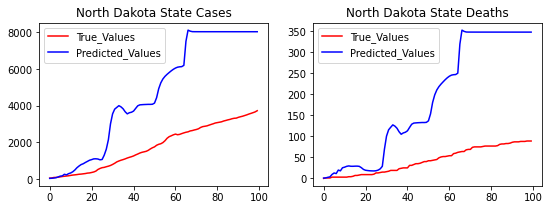

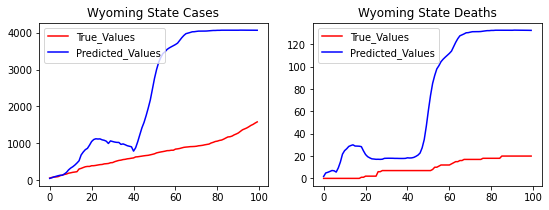

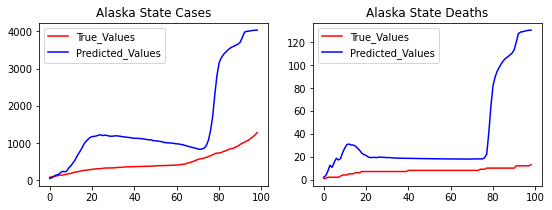

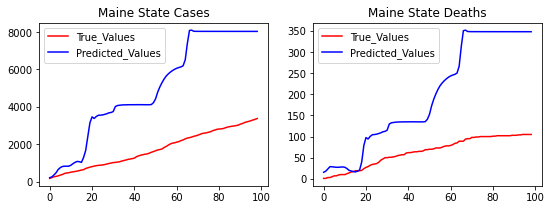

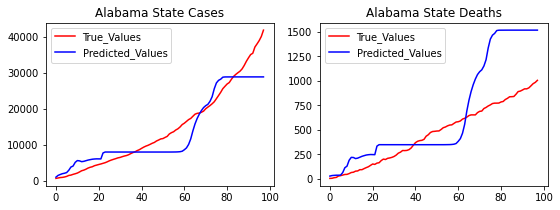

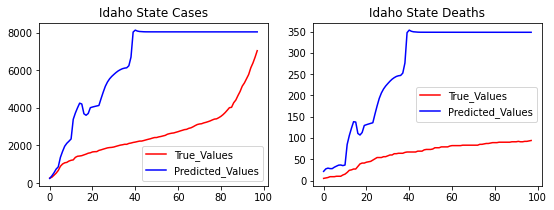

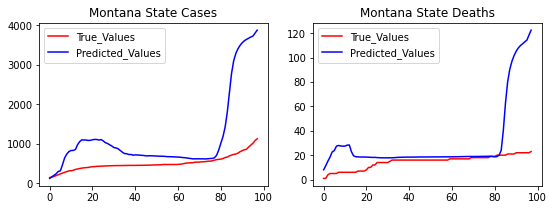

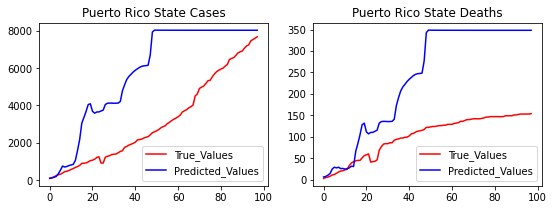

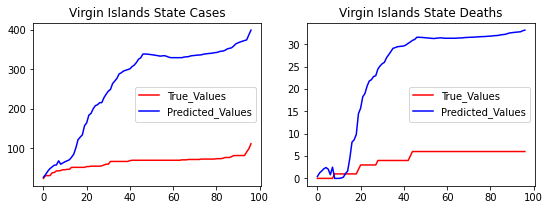

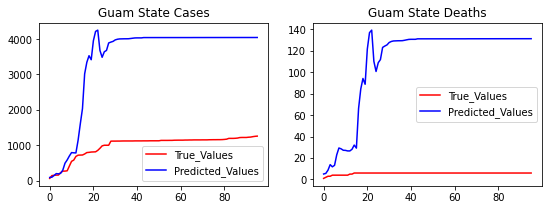

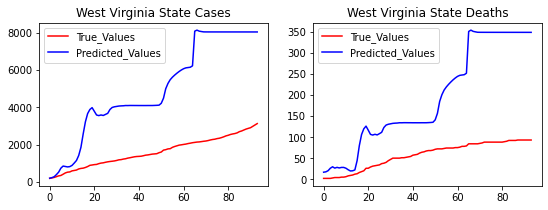

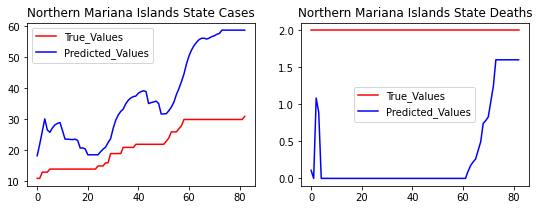

In [144]:
n_len = 15
states = df['state'].unique()

for state in states[:]:
  df3 = df[df['state']==state]
  if df3.shape[0]<80:
    continue
  df3 = df3[['cases', 'deaths']]
  df3 = df3.iloc[:,:].values
  testX, testY = processValData(df3, n_len)
  predictedValues = new_indyModel.predict(testX)
  #print(predictedValues[:,1])
  for i in range(predictedValues.shape[0]):
    for j in range(predictedValues.shape[1]):
      #predictedValues[i,j] = int(predictedValues[i,j])
      if predictedValues[i,j]<0:
        predictedValues[i,j] = 0



  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3))
  ax1.plot(testY[:,0],color = 'red', label = 'True_Values')
  ax1.plot(predictedValues[:,0], color = 'blue', label = 'Predicted_Values')
  ax1.set_title(state + ' State Cases')
  ax1.legend()
  ax2.plot(testY[:,1],color = 'red', label = 'True_Values')
  ax2.plot(predictedValues[:,1], color = 'blue', label = 'Predicted_Values')
  ax2.set_title(state + ' State Deaths')
  ax2.legend()

#   ax3.plot(testY[:,2],color = 'red', label = 'True_Values')
#   ax3.plot(predictedValues[:,2], color = 'blue', label = 'Predicted_Values')
#   ax3.set_title(state + ' State Hospitalized Currently')
#   ax3.legend()
#   ax4.plot(testY[:,3],color = 'red', label = 'True_Values')
#   ax4.plot(predictedValues[:,3], color = 'blue', label = 'Predicted_Values')
#   ax4.set_title(state + ' State on Ventilator Currently')
#   ax4.legend()

#   ax5.plot(testY[:,4],color = 'red', label = 'True_Values')
#   ax5.plot(predictedValues[:,4], color = 'blue', label = 'Predicted_Values')
#   ax5.set_title(state + ' State in ICU Currently')
#   ax5.legend()
#   ax6.plot(testY[:,5],color = 'red', label = 'True_Values')
#   ax6.plot(predictedValues[:,5], color = 'blue', label = 'Predicted_Values')
#   ax6.set_title(state + ' State Recovered')
#   ax6.legend()

#   ax7.plot(testY[:,6],color = 'red', label = 'True_Values')
#   ax7.plot(predictedValues[:,6], color = 'blue', label = 'Predicted_Values')
#   ax7.set_title(state + ' State Deaths')
#   ax7.legend()